# Проект: Обучение с учителем: качество модели

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

**Цели**:
- промаркировать уровень финансовой активности постоянных покупателей
- собрать данные по клиентам следующих групп:
  - Признаки, которые описывают коммуникацию сотрудников компании с клиентом
  - Признаки, которые описывают продуктовое поведение покупателя
  - Признаки, которые описывают покупательское поведение клиента
  - Признаки, которые описывают поведение покупателя на сайте

**Ход исследования**:
- Загрузка данных
- Предобработка данных
- Исследовательский анализ данных
- Корреляционный анализ
- Пайплайны
- Анализ важности признаков
- Сегментация пользователей
- Общий вывод

**Содержание**:
- [Загрузка данных](#first-bullet)
- [Предобработка данных](#second-bullet)
- [Исследовательский анализ данных](#third-bullet)
- [Объединение таблиц](#fourth-bullet)
- [Корреляционный анализ](#fifth-bullet)
- [Пайплайны](#sixth-bullet)
- [Анализ важности признаков](#seventh-bullet)
- [Сегментация пользователей](#eighth-bullet)
- [Общий вывод](#ninth-bullet)

In [3]:
!pip install -q --force-reinstall \
    "numpy<2" \
    "pandas" \
    "scipy" \
    "pyarrow" \
    "scikit-learn" \
    "imbalanced-learn" \
    "matplotlib" \
    "seaborn" \
    "phik" \
    "shap" \
    "optuna" \
    "optuna-integration[sklearn]"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.16.1 which is incompatible.
streamlit 1.37.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.
streamlit 1.37.1 requires pillow<11,>=7.1.0, but you have pillow 11.3.0 which is incompatible.


In [4]:
import pandas as pd
import optuna
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from cycler import cycler
import seaborn as sns

import numpy as np
from scipy import stats as st
import phik

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score

from optuna import distributions
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, CategoricalDistribution, LogUniformDistribution

from sklearn.inspection import permutation_importance
import shap

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

RANDOM_STATE = 42
TEST_SIZE = 0.25

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

<a class='anchor' id='first-bullet'></a>
## Загрузка данных

In [6]:
data_customer = pd.read_csv('market_file.csv', index_col='id')
data_customer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348 to 216647
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1300 non-null   object 
 1   Тип сервиса                          1300 non-null   object 
 2   Разрешить сообщать                   1300 non-null   object 
 3   Маркет_актив_6_мес                   1300 non-null   float64
 4   Маркет_актив_тек_мес                 1300 non-null   int64  
 5   Длительность                         1300 non-null   int64  
 6   Акционные_покупки                    1300 non-null   float64
 7   Популярная_категория                 1300 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  Ошибка_сервиса                       1300 non-null   int64  
 11  Страниц_за_визит            

In [7]:
data_customer.head()

Покупательская активность Тип сервиса Разрешить сообщать  \
id                                                                
215348                 Снизилась     премиум                 да   
215349                 Снизилась     премиум                 да   
215350                 Снизилась   стандартт                нет   
215351                 Снизилась   стандартт                 да   
215352                 Снизилась   стандартт                нет   

        Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
id                                                               
215348                 3.4                     5           121   
215349                 4.4                     4           819   
215350                 4.9                     3           539   
215351                 3.2                     5           896   
215352                 5.1                     3          1064   

        Акционные_покупки Популярная_категория  \
id                                               
215348               0.00     Товары для детей   
215349               0.75     Товары для детей   
215350               0.14    Домашний текстиль   
215351               0.99     Товары для детей   
215352               0.94     Товары для детей   

        Средний_просмотр_категорий_за_визит  \
id                                            
215348                                    6   
215349                                    4   
215350                                    5   
215351                                    5   
215352                                    3   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
id                                                                            
215348                                   2               1                 5  
215349                                   4               2                 5  
215350                                   2               1                 5  
215351                                   0               6                 4  
215352                                   2               3                 2

In [8]:
data_money = pd.read_csv('market_money.csv', index_col='id')
data_money.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3900 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Период   3900 non-null   object 
 1   Выручка  3900 non-null   float64
dtypes: float64(1), object(1)
memory usage: 91.4+ KB


In [9]:
data_money.head()

Период  Выручка
id                                  
215348  препредыдущий_месяц      0.0
215348        текущий_месяц   3293.1
215348     предыдущий_месяц      0.0
215349  препредыдущий_месяц   4472.0
215349        текущий_месяц   4971.6

In [10]:
data_time = pd.read_csv('market_time.csv', index_col='id')
data_time.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2600 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Период  2600 non-null   object
 1   минут   2600 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 60.9+ KB


In [11]:
data_time.head()

Период  минут
id                             
215348     текущий_месяц     14
215348  предыдцщий_месяц     13
215349     текущий_месяц     10
215349  предыдцщий_месяц     12
215350     текущий_месяц     13

In [12]:
data_income = pd.read_csv('money.csv', sep=';', index_col='id', decimal=',')
data_income.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348 to 216647
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Прибыль  1300 non-null   float64
dtypes: float64(1)
memory usage: 20.3 KB


In [13]:
data_income.head()

Прибыль
id             
215348     0.98
215349     4.16
215350     3.13
215351     4.87
215352     4.21

По результатам ознакомления с данными, можно сказать что данных у нас не очень много, в самой большой таблице всего 3900 наблюдений, также можно отметить, что на первый взгляд в данных нет пропусков, однако есть грамматические ошибки в некоторых категориальных данных

<a class='anchor' id='second-bullet'></a>
## Предобработка данных

Для начала переименуем столбцы

In [17]:
data_customer = data_customer.rename(columns={
    'Покупательская активность': 'customer_activity',
    'Тип сервиса': 'service_type',
    'Разрешить сообщать': 'allow_ad',
    'Маркет_актив_6_мес': 'ads_6_months',
    'Маркет_актив_тек_мес': 'ads_cur_month',
    'Длительность': 'duration',
    'Акционные_покупки': 'prom_purchases',
    'Популярная_категория': 'popular_category',
    'Средний_просмотр_категорий_за_визит': 'mean_category_views_per_visit',
    'Неоплаченные_продукты_штук_квартал': 'unpaid_products_quater',
    'Ошибка_сервиса': 'service_error',
    'Страниц_за_визит': 'pages_per_visit'
})

In [18]:
data_money = data_money.rename(columns={
    'Период': 'period',
    'Выручка': 'income'
})

In [19]:
data_time = data_time.rename(columns={
    'Период': 'period',
    'минут': 'minutes'
})

In [20]:
data_income = data_income.rename(columns={
    'Прибыль': 'income'
})

In [21]:
data_income.head()

income
id            
215348    0.98
215349    4.16
215350    3.13
215351    4.87
215352    4.21

Теперь проверим типы данных и пропуски

In [23]:
data_customer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348 to 216647
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_activity              1300 non-null   object 
 1   service_type                   1300 non-null   object 
 2   allow_ad                       1300 non-null   object 
 3   ads_6_months                   1300 non-null   float64
 4   ads_cur_month                  1300 non-null   int64  
 5   duration                       1300 non-null   int64  
 6   prom_purchases                 1300 non-null   float64
 7   popular_category               1300 non-null   object 
 8   mean_category_views_per_visit  1300 non-null   int64  
 9   unpaid_products_quater         1300 non-null   int64  
 10  service_error                  1300 non-null   int64  
 11  pages_per_visit                1300 non-null   int64  
dtypes: float64(2), int64(6), object(4)
memory usag

In [24]:
data_customer.head()

customer_activity service_type allow_ad  ads_6_months  ads_cur_month  \
id                                                                            
215348         Снизилась      премиум       да           3.4              5   
215349         Снизилась      премиум       да           4.4              4   
215350         Снизилась    стандартт      нет           4.9              3   
215351         Снизилась    стандартт       да           3.2              5   
215352         Снизилась    стандартт      нет           5.1              3   

        duration  prom_purchases   popular_category  \
id                                                    
215348       121            0.00   Товары для детей   
215349       819            0.75   Товары для детей   
215350       539            0.14  Домашний текстиль   
215351       896            0.99   Товары для детей   
215352      1064            0.94   Товары для детей   

        mean_category_views_per_visit  unpaid_products_quater  service_error  \
id                                                                             
215348                              6                       2              1   
215349                              4                       4              2   
215350                              5                       2              1   
215351                              5                       0              6   
215352                              3                       2              3   

        pages_per_visit  
id                       
215348                5  
215349                5  
215350                5  
215351                4  
215352                2

In [25]:
data_money.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3900 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   period  3900 non-null   object 
 1   income  3900 non-null   float64
dtypes: float64(1), object(1)
memory usage: 91.4+ KB


In [26]:
data_money.head()

period  income
id                                 
215348  препредыдущий_месяц     0.0
215348        текущий_месяц  3293.1
215348     предыдущий_месяц     0.0
215349  препредыдущий_месяц  4472.0
215349        текущий_месяц  4971.6

In [27]:
data_time.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2600 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   period   2600 non-null   object
 1   minutes  2600 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 60.9+ KB


In [28]:
data_time.head()

period  minutes
id                               
215348     текущий_месяц       14
215348  предыдцщий_месяц       13
215349     текущий_месяц       10
215349  предыдцщий_месяц       12
215350     текущий_месяц       13

In [29]:
data_income.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348 to 216647
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   income  1300 non-null   float64
dtypes: float64(1)
memory usage: 20.3 KB


In [30]:
data_income.head()

income
id            
215348    0.98
215349    4.16
215350    3.13
215351    4.87
215352    4.21

Все типы верные и пропусков в данных нет

Теперь проверим неявные дубликаты

In [33]:
data_customer.head()

customer_activity service_type allow_ad  ads_6_months  ads_cur_month  \
id                                                                            
215348         Снизилась      премиум       да           3.4              5   
215349         Снизилась      премиум       да           4.4              4   
215350         Снизилась    стандартт      нет           4.9              3   
215351         Снизилась    стандартт       да           3.2              5   
215352         Снизилась    стандартт      нет           5.1              3   

        duration  prom_purchases   popular_category  \
id                                                    
215348       121            0.00   Товары для детей   
215349       819            0.75   Товары для детей   
215350       539            0.14  Домашний текстиль   
215351       896            0.99   Товары для детей   
215352      1064            0.94   Товары для детей   

        mean_category_views_per_visit  unpaid_products_quater  service_error  \
id                                                                             
215348                              6                       2              1   
215349                              4                       4              2   
215350                              5                       2              1   
215351                              5                       0              6   
215352                              3                       2              3   

        pages_per_visit  
id                       
215348                5  
215349                5  
215350                5  
215351                4  
215352                2

In [34]:
data_customer['customer_activity'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [35]:
data_customer['service_type'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [36]:
data_customer['service_type'] = data_customer['service_type'].replace('стандартт', 'стандарт')

In [37]:
data_customer['service_type'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [38]:
data_customer['allow_ad'].unique()

array(['да', 'нет'], dtype=object)

In [39]:
data_customer['popular_category'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [40]:
data_customer['popular_category'] = data_customer['popular_category'].replace('Косметика и аксесуары', 'Косметика и аксессуары')

In [41]:
data_customer['popular_category'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксессуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [42]:
data_money.head()

period  income
id                                 
215348  препредыдущий_месяц     0.0
215348        текущий_месяц  3293.1
215348     предыдущий_месяц     0.0
215349  препредыдущий_месяц  4472.0
215349        текущий_месяц  4971.6

In [43]:
data_money['period'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [44]:
data_time.head()

period  minutes
id                               
215348     текущий_месяц       14
215348  предыдцщий_месяц       13
215349     текущий_месяц       10
215349  предыдцщий_месяц       12
215350     текущий_месяц       13

In [45]:
data_time['period'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [46]:
data_time['period'] = data_time['period'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [47]:
data_time['period'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [48]:
data_income.head()

income
id            
215348    0.98
215349    4.16
215350    3.13
215351    4.87
215352    4.21

Проверил на наличие неявных дубликатов, исправил их

Теперь проверим на наличие явных дубликатов

In [51]:
data_customer.duplicated().sum()

11

In [52]:
data_customer[data_customer.duplicated(keep=False)]

customer_activity service_type allow_ad  ads_6_months  ads_cur_month  \
id                                                                            
215685         Снизилась     стандарт      нет           4.4              5   
215686         Снизилась     стандарт      нет           4.3              4   
215687         Снизилась     стандарт       да           3.9              4   
215688         Снизилась     стандарт       да           5.5              4   
215689         Снизилась     стандарт      нет           5.0              4   
215690         Снизилась     стандарт       да           4.8              4   
215691         Снизилась     стандарт      нет           3.9              5   
215692         Снизилась     стандарт       да           3.3              3   
215693         Снизилась     стандарт       да           5.6              5   
215694         Снизилась      премиум       да           5.5              5   
215695         Снизилась     стандарт       да           4.3              4   
215895         Снизилась     стандарт      нет           4.4              5   
215896         Снизилась     стандарт      нет           4.3              4   
215897         Снизилась     стандарт       да           3.9              4   
215898         Снизилась     стандарт       да           5.5              4   
215899         Снизилась     стандарт      нет           5.0              4   
215900         Снизилась     стандарт       да           4.8              4   
215901         Снизилась     стандарт      нет           3.9              5   
215902         Снизилась     стандарт       да           3.3              3   
215903         Снизилась     стандарт       да           5.6              5   
215904         Снизилась      премиум       да           5.5              5   
215905         Снизилась     стандарт       да           4.3              4   

        duration  prom_purchases                      popular_category  \
id                                                                       
215685       517            0.23                      Товары для детей   
215686       460            0.16        Техника для красоты и здоровья   
215687       627            0.24                      Товары для детей   
215688       703            0.14  Мелкая бытовая техника и электроника   
215689       136            0.27                      Товары для детей   
215690       907            0.30                Косметика и аксессуары   
215691       600            0.17                     Домашний текстиль   
215692       871            0.20        Техника для красоты и здоровья   
215693       574            0.28                     Домашний текстиль   
215694       982            0.94  Мелкая бытовая техника и электроника   
215695       324            0.14        Техника для красоты и здоровья   
215895       517            0.23                      Товары для детей   
215896       460            0.16        Техника для красоты и здоровья   
215897       627            0.24                      Товары для детей   
215898       703            0.14  Мелкая бытовая техника и электроника   
215899       136            0.27                      Товары для детей   
215900       907            0.30                Косметика и аксессуары   
215901       600            0.17                     Домашний текстиль   
215902       871            0.20        Техника для красоты и здоровья   
215903       574            0.28                     Домашний текстиль   
215904       982            0.94  Мелкая бытовая техника и электроника   
215905       324            0.14        Техника для красоты и здоровья   

        mean_category_views_per_visit  unpaid_products_quater  service_error  \
id                                                                             
215685                              1                       2              5   
215686                              2                       1              3   
215687       

Как мы видим дубликаты это разные покупатели, просто с одинаковой статистикой, в остальных таблицах скорее всего тоже самое

In [54]:
data_money.duplicated().sum()

746

In [55]:
data_time.duplicated().sum()

2561

In [56]:
data_income.duplicated().sum()

900

Так как pandas не жаловался на одинаковые id, следовательно это просто одинаковая статистика разных покупателей

По итогам предобработки данных, я удалил неявные дубликаты, переименовал колонки, проверил типы данных, пропуски и явные дубликаты

<a class='anchor' id='third-bullet'></a>
## Исследовательский анализ данных

Анализ количественных признаков

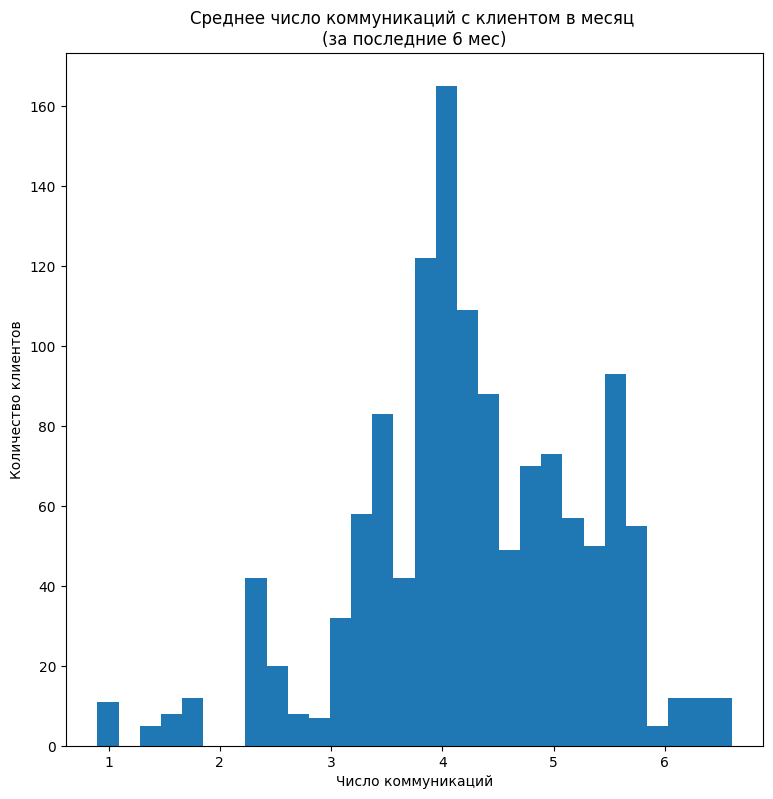

In [61]:
data_customer['ads_6_months'].plot.hist(bins=30, figsize=(9, 9))
plt.title('Среднее число коммуникаций с клиентом в месяц \n(за последние 6 мес)')
plt.ylabel('Количество клиентов')
plt.xlabel('Число коммуникаций')
plt.show()

График отдаленно напоминает нормальное распределение

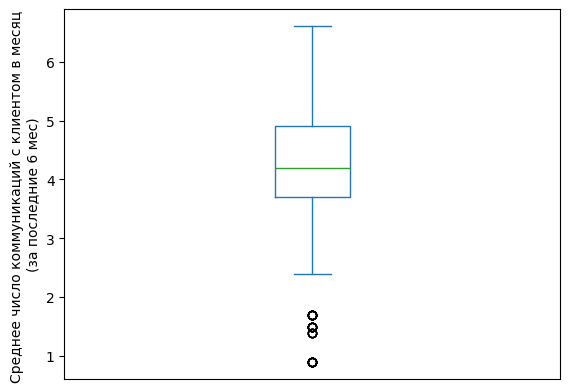

In [63]:
data_customer['ads_6_months'].plot.box()
plt.ylabel('Среднее число коммуникаций с клиентом в месяц \n(за последние 6 мес)')
plt.xticks([])
plt.show()

Видим, что некоторое количество значений явно уходит за пределы первого квантиля.

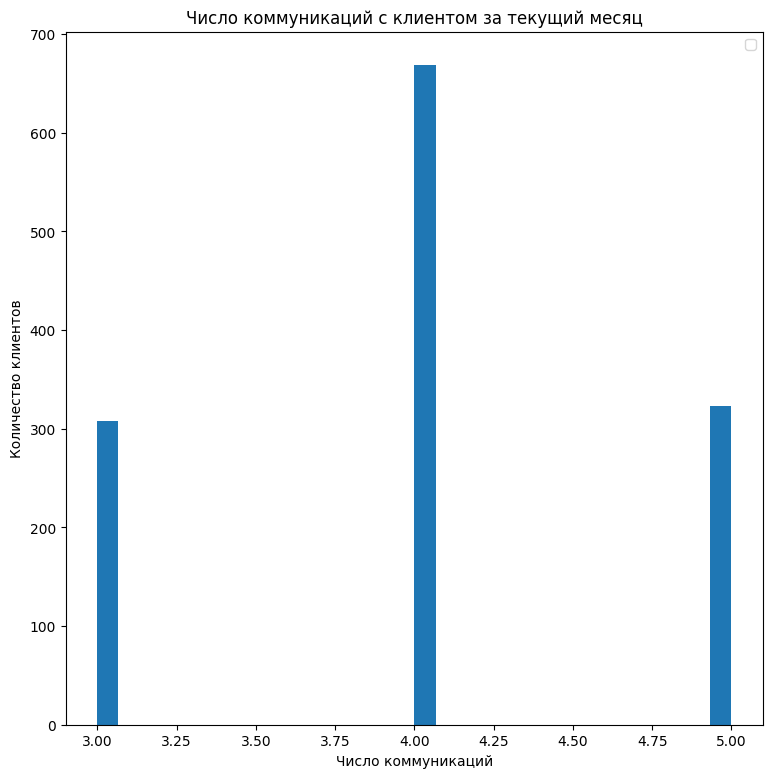

In [65]:
data_customer['ads_cur_month'].plot.hist(bins=30, figsize=(9, 9))
plt.title('Число коммуникаций с клиентом за текущий месяц')
plt.legend(labels=[])
plt.ylabel('Количество клиентов')
plt.xlabel('Число коммуникаций')
plt.show()

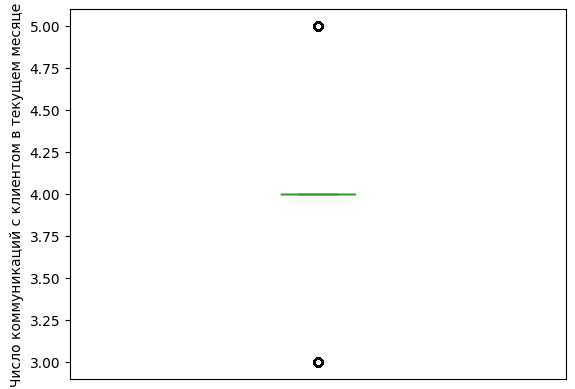

In [66]:
data_customer['ads_cur_month'].plot.box()
plt.ylabel('Число коммуникаций с клиентом в текущем месяце')
plt.xticks([])
plt.show()

Видно, что число коммуникаций принимает 3 значения 3, 4 и 5, можно сделать это категориальным признаком

In [68]:
data_customer['ads_cur_month_cat'] = data_customer['ads_cur_month'].apply(
    lambda x : 'низкий' if x == 3 else 'средний' if x == 4 else 'высокий'
)

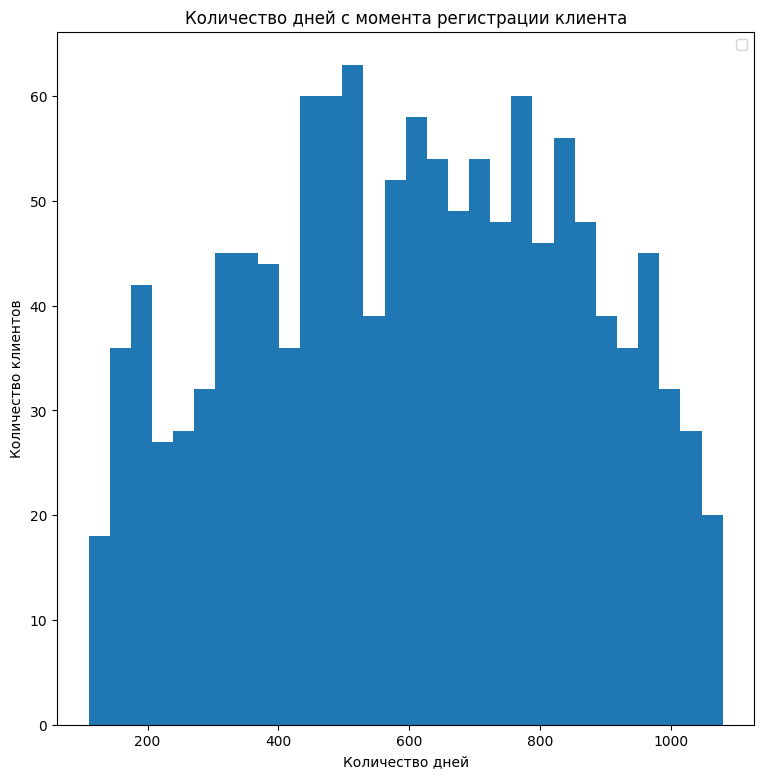

In [69]:
data_customer['duration'].plot.hist(bins=30, figsize=(9, 9))
plt.title('Количество дней с момента регистрации клиента')
plt.legend(labels=[])
plt.ylabel('Количество клиентов')
plt.xlabel('Количество дней')
plt.show()

Распределение похоже на равномерное

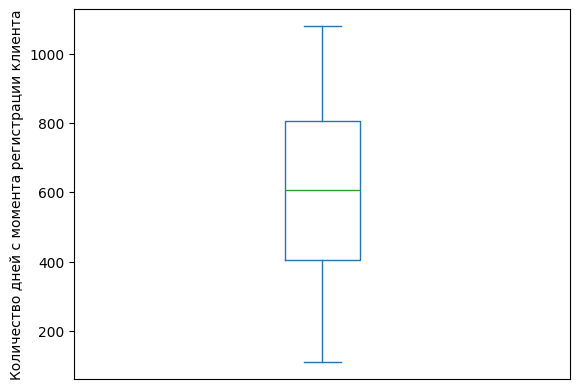

In [71]:
data_customer['duration'].plot.box()
plt.ylabel('Количество дней с момента регистрации клиента')
plt.xticks([])
plt.show()

Все значения находятся в пределах нормы. Возможно, во время подготовки данных к обучению удастся выловить нелинейную связь этого признака с целевым.

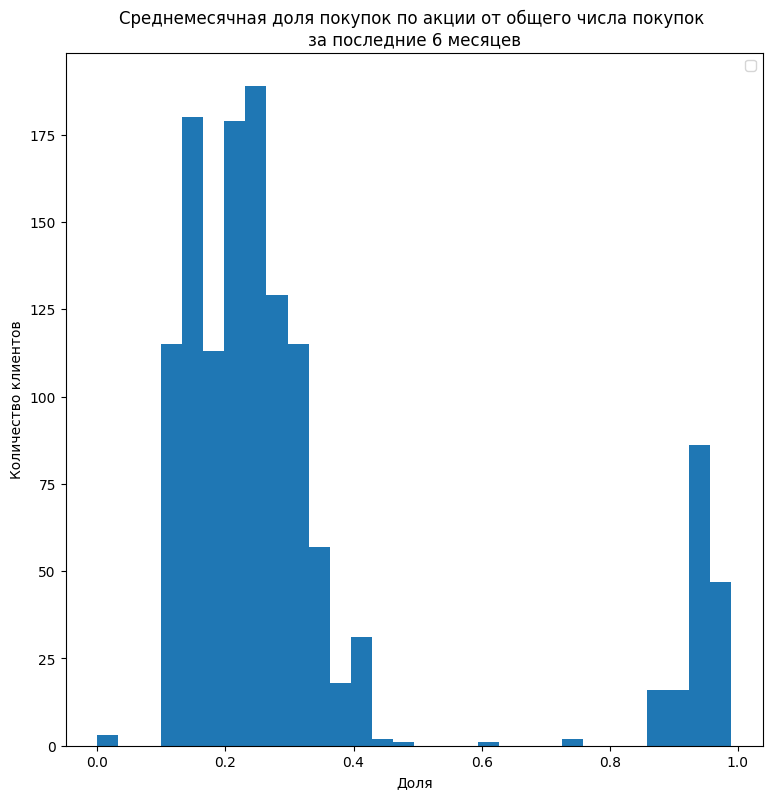

In [73]:
data_customer['prom_purchases'].plot.hist(bins=30, figsize=(9, 9))
plt.title('Cреднемесячная доля покупок по акции от общего числа покупок \nза последние 6 месяцев')
plt.legend(labels=[])
plt.ylabel('Количество клиентов')
plt.xlabel('Доля')
plt.show()

Здесь точно можно выделить категориальный признак с разделением в районе 0.7

In [75]:
data_customer['prom_purchases_cat'] = data_customer['prom_purchases'].apply(lambda x: '<70%' if x < 0.7 else '>70%')

<Axes: xlabel='prom_purchases_cat'>

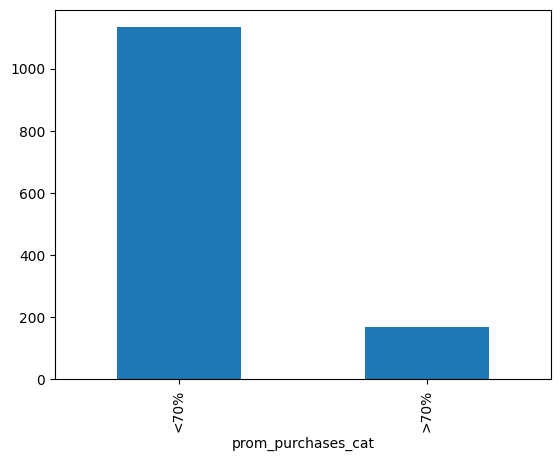

In [76]:
data_customer['prom_purchases_cat'].value_counts().plot.bar()

Тут конечно высокий дисбаланс, но оставим, может пригодится при обучении

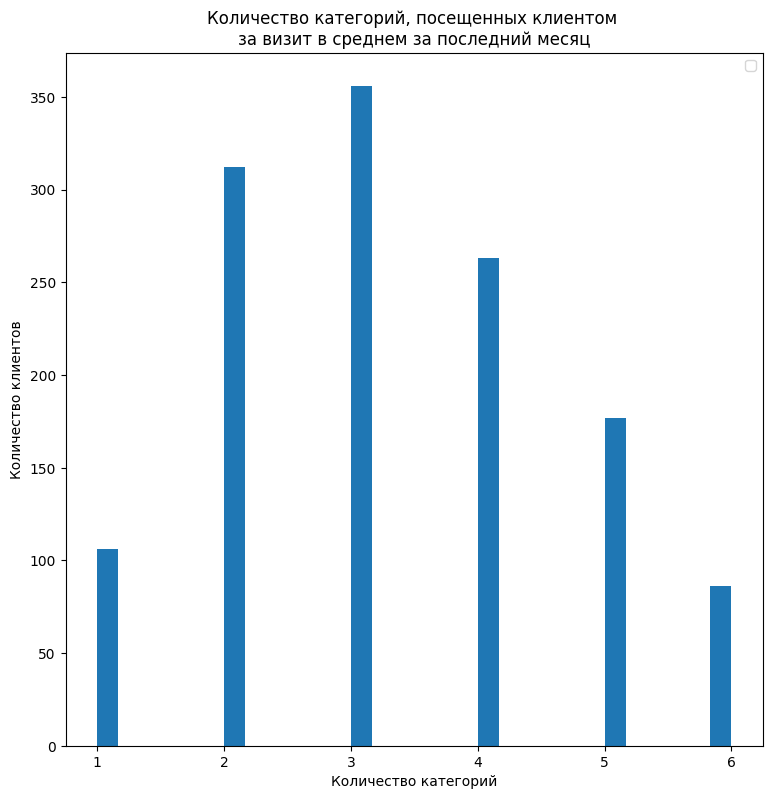

In [78]:
data_customer['mean_category_views_per_visit'].plot.hist(bins=30, figsize=(9, 9))
plt.title('Количество категорий, посещенных клиентом \nза визит в среднем за последний месяц')
plt.legend(labels=[])
plt.ylabel('Количество клиентов')
plt.xlabel('Количество категорий')
plt.show()

Распределение похоже на нормальное со сдвигом влево

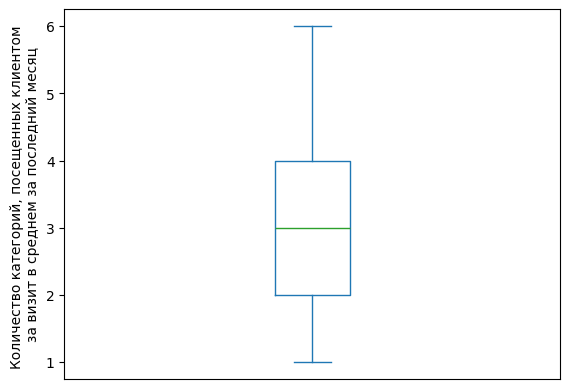

In [80]:
data_customer['mean_category_views_per_visit'].plot.box()
plt.ylabel('Количество категорий, посещенных клиентом \nза визит в среднем за последний месяц')
plt.xticks([])
plt.show()

Все значенияв пределах нормы

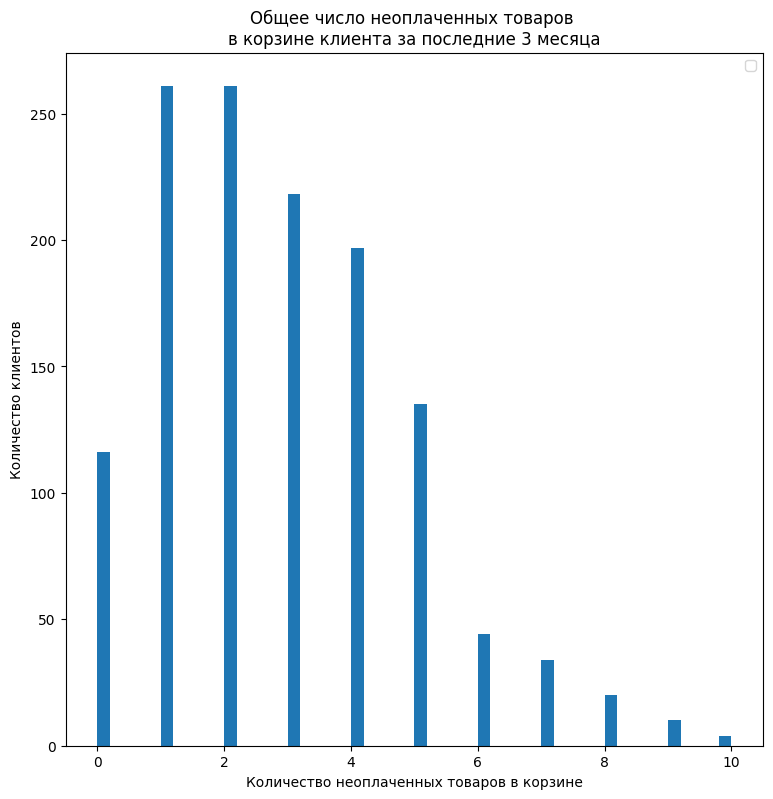

In [82]:
data_customer['unpaid_products_quater'].plot.hist(bins=50, figsize=(9, 9))
plt.title('Общее число неоплаченных товаров \nв корзине клиента за последние 3 месяца')
plt.legend(labels=[])
plt.ylabel('Количество клиентов')
plt.xlabel('Количество неоплаченных товаров в корзине')
plt.show()

Похоже на распределение пуассона

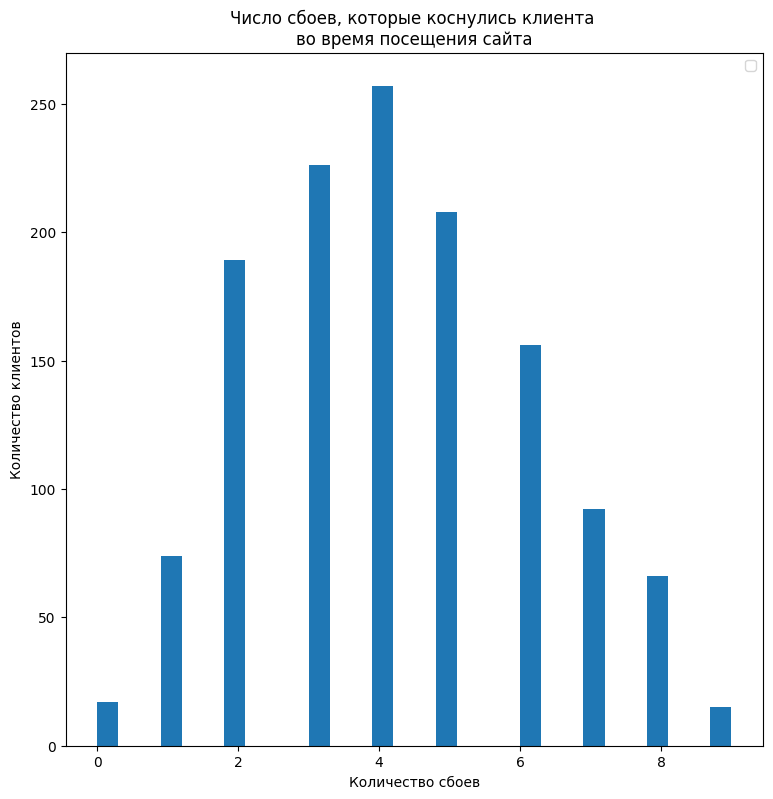

In [84]:
data_customer['service_error'].plot.hist(bins=30, figsize=(9, 9))
plt.title('Число сбоев, которые коснулись клиента \nво время посещения сайта')
plt.legend(labels=[])
plt.ylabel('Количество клиентов')
plt.xlabel('Количество сбоев')
plt.show()

В целом распределение похоже на нормальное.

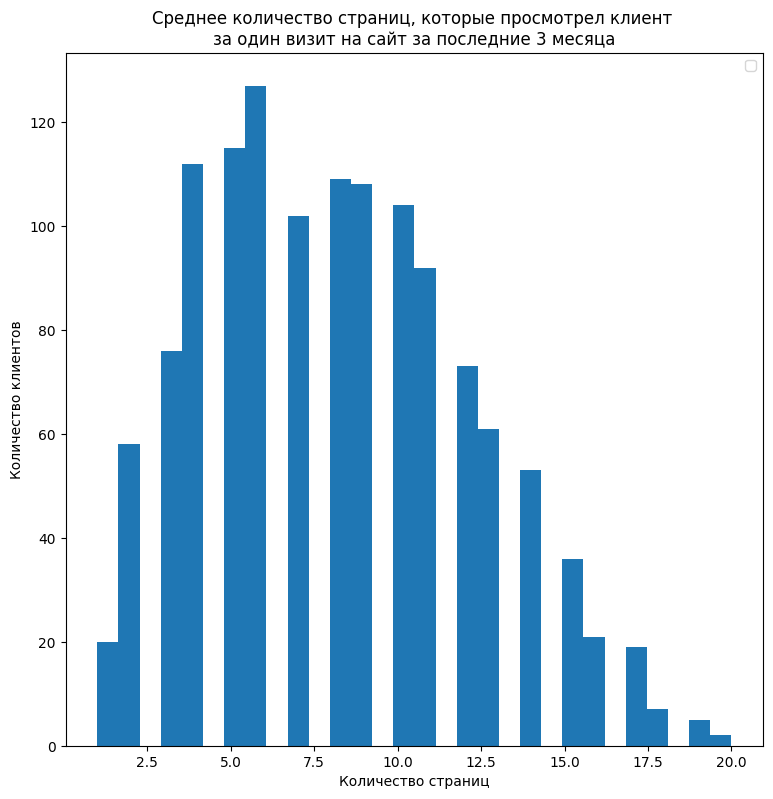

In [86]:
data_customer['pages_per_visit'].plot.hist(bins=30, figsize=(9, 9))
plt.title('Среднее количество страниц, которые просмотрел клиент \nза один визит на сайт за последние 3 месяца')
plt.legend(labels=[])
plt.ylabel('Количество клиентов')
plt.xlabel('Количество страниц')
plt.show()

Выглядит как два наложенных друг на друга нормальных распределения со сдвигом влево

In [88]:
data_money.head()

period  income
id                                 
215348  препредыдущий_месяц     0.0
215348        текущий_месяц  3293.1
215348     предыдущий_месяц     0.0
215349  препредыдущий_месяц  4472.0
215349        текущий_месяц  4971.6

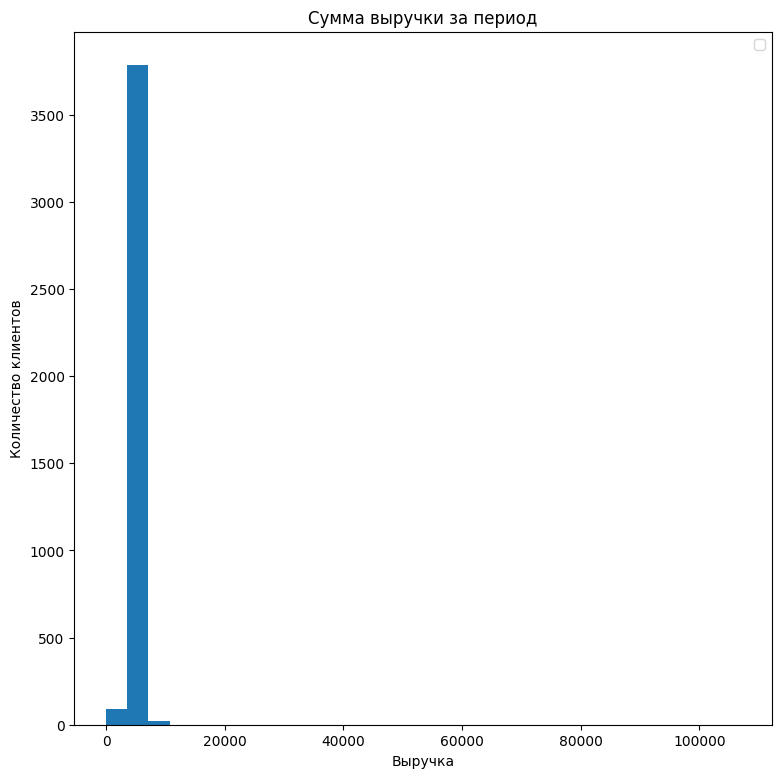

In [89]:
data_money['income'].plot.hist(bins=30, figsize=(9, 9))
plt.title('Сумма выручки за период')
plt.legend(labels=[])
plt.ylabel('Количество клиентов')
plt.xlabel('Выручка')
plt.show()

Выбросы точно имеют место. Построим боксплот:

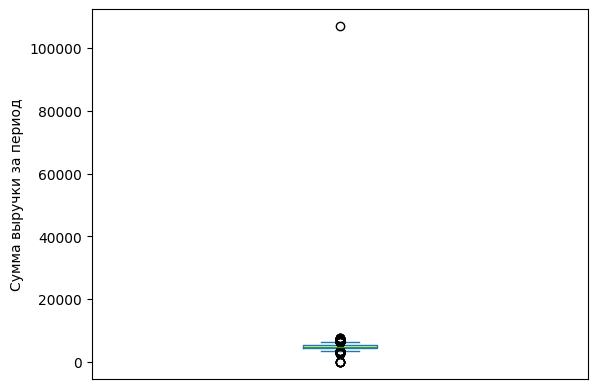

In [91]:
data_money['income'].plot.box()
plt.ylabel('Cумма выручки за период')
plt.xticks([])
plt.show()

In [92]:
data_money['income'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: income, dtype: float64

In [93]:
data_money = data_money.query('income < 100000')

Избавимся от этой аномалии

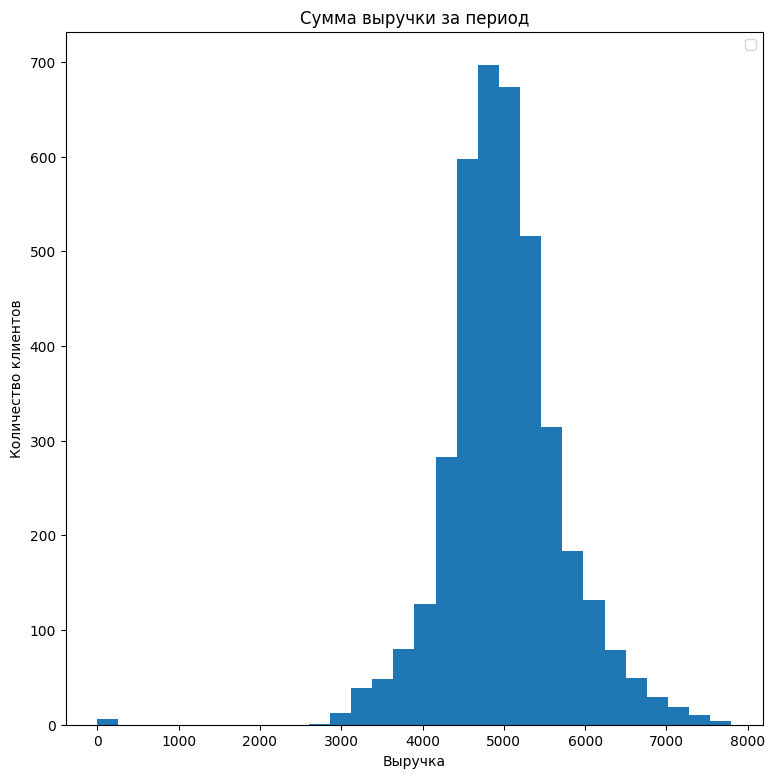

In [95]:
data_money['income'].plot.hist(bins=30, figsize=(9, 9))
plt.title('Сумма выручки за период')
plt.legend(labels=[])
plt.ylabel('Количество клиентов')
plt.xlabel('Выручка')
plt.show()

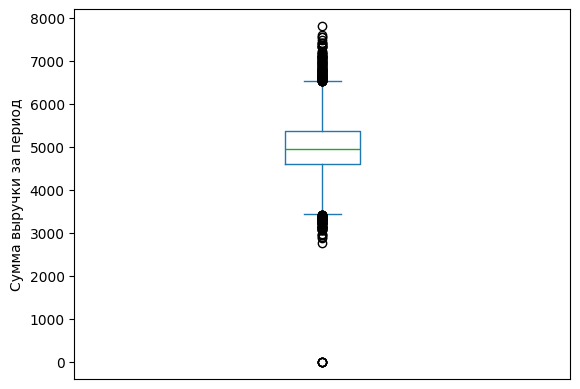

In [96]:
data_money['income'].plot.box()
plt.ylabel('Cумма выручки за период')
plt.xticks([])
plt.show()

Видим выбросы в районе 0. Но совершенно логично, что некоторые клиенты не совершали покупок в определенные периоды

In [98]:
data_time.head()

period  minutes
id                               
215348     текущий_месяц       14
215348  предыдущий_месяц       13
215349     текущий_месяц       10
215349  предыдущий_месяц       12
215350     текущий_месяц       13

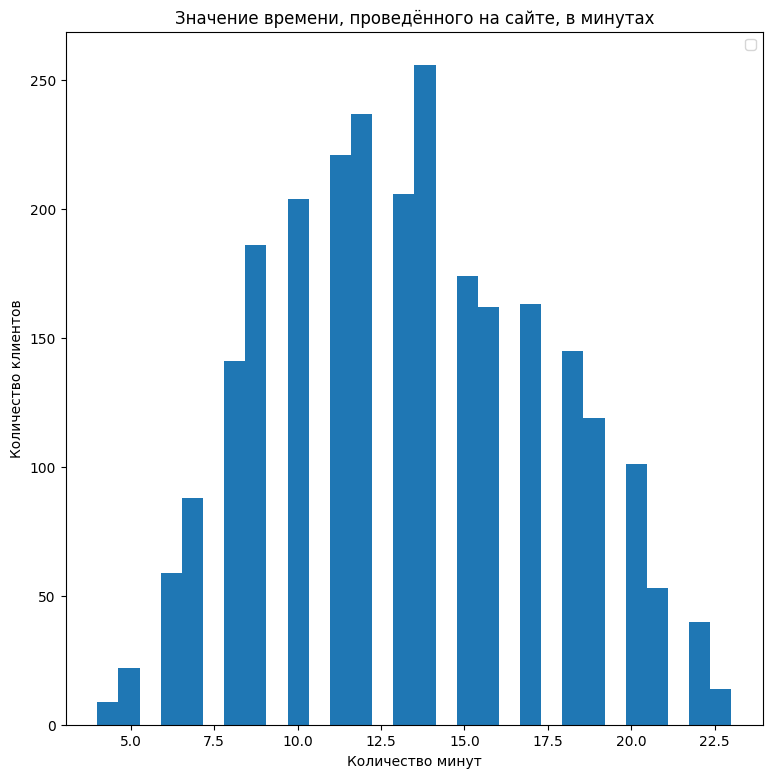

In [99]:
data_time['minutes'].plot.hist(bins=30, figsize=(9, 9))
plt.title('Значение времени, проведённого на сайте, в минутах')
plt.legend(labels=[])
plt.ylabel('Количество клиентов')
plt.xlabel('Количество минут')
plt.show()

Распределение похоже на нормальное

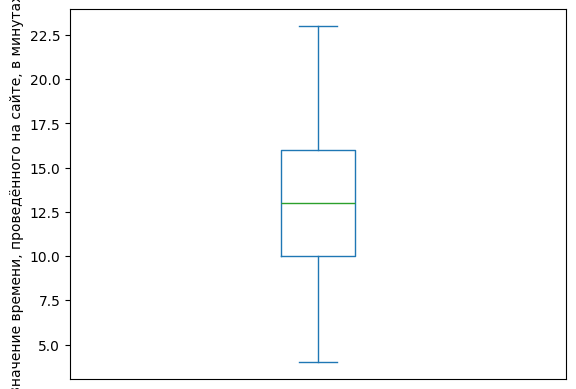

In [101]:
data_time['minutes'].plot.box()
plt.ylabel('Значение времени, проведённого на сайте, в минутах')
plt.xticks([])
plt.show()

Все значения в пределах нормы

In [103]:
data_income.head()

income
id            
215348    0.98
215349    4.16
215350    3.13
215351    4.87
215352    4.21

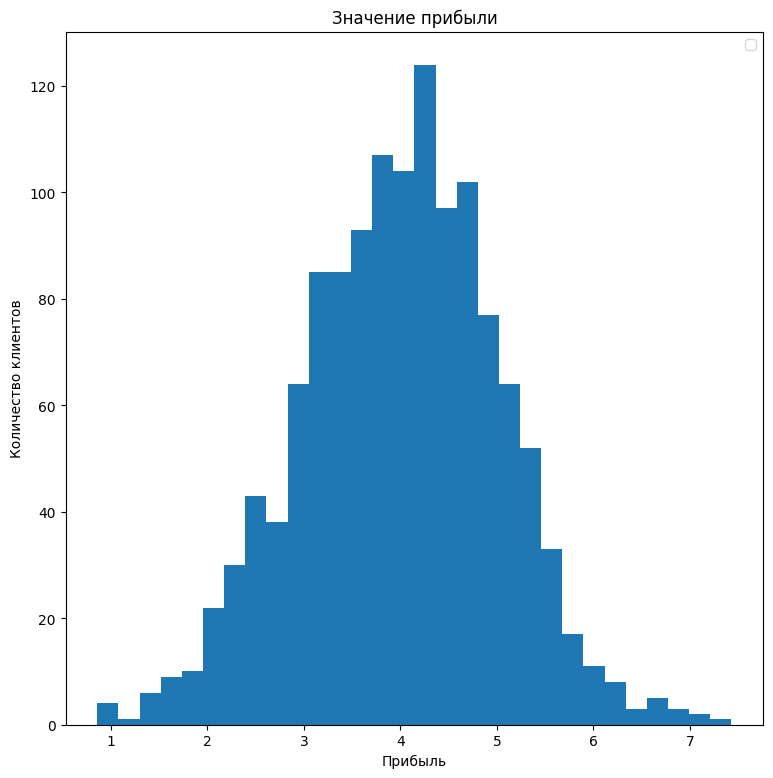

In [104]:
data_income['income'].plot.hist(bins=30, figsize=(9, 9))
plt.title('Значение прибыли')
plt.legend(labels=[])
plt.ylabel('Количество клиентов')
plt.xlabel('Прибыль')
plt.show()

Распределение похоже на нормальное

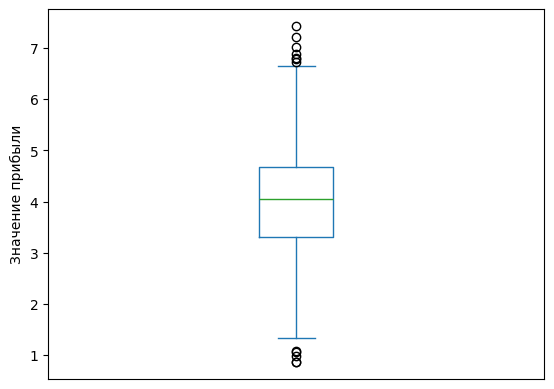

In [106]:
data_income['income'].plot.box()
plt.ylabel('Значение прибыли')
plt.xticks([])
plt.show()

Значения мало отклоняются от нормы. Обработка не требуется

Анализ категориальных признаков

In [109]:
data_customer.head()

customer_activity service_type allow_ad  ads_6_months  ads_cur_month  \
id                                                                            
215348         Снизилась      премиум       да           3.4              5   
215349         Снизилась      премиум       да           4.4              4   
215350         Снизилась     стандарт      нет           4.9              3   
215351         Снизилась     стандарт       да           3.2              5   
215352         Снизилась     стандарт      нет           5.1              3   

        duration  prom_purchases   popular_category  \
id                                                    
215348       121            0.00   Товары для детей   
215349       819            0.75   Товары для детей   
215350       539            0.14  Домашний текстиль   
215351       896            0.99   Товары для детей   
215352      1064            0.94   Товары для детей   

        mean_category_views_per_visit  unpaid_products_quater  service_error  \
id                                                                             
215348                              6                       2              1   
215349                              4                       4              2   
215350                              5                       2              1   
215351                              5                       0              6   
215352                              3                       2              3   

        pages_per_visit ads_cur_month_cat prom_purchases_cat  
id                                                            
215348                5           высокий               <70%  
215349                5           средний               >70%  
215350                5            низкий               <70%  
215351                4           высокий               >70%  
215352                2            низкий               >70%

In [110]:
def show_bar(name, table, ax):
    pivot = table[name].value_counts()
    pivot.sort_values(ascending=True, inplace=True)

    return pivot.plot.bar(title=name,
                   legend='',
                   xlabel='',
                   ylabel='Количество пользователей',
                   rot=0,
                   ax=ax)

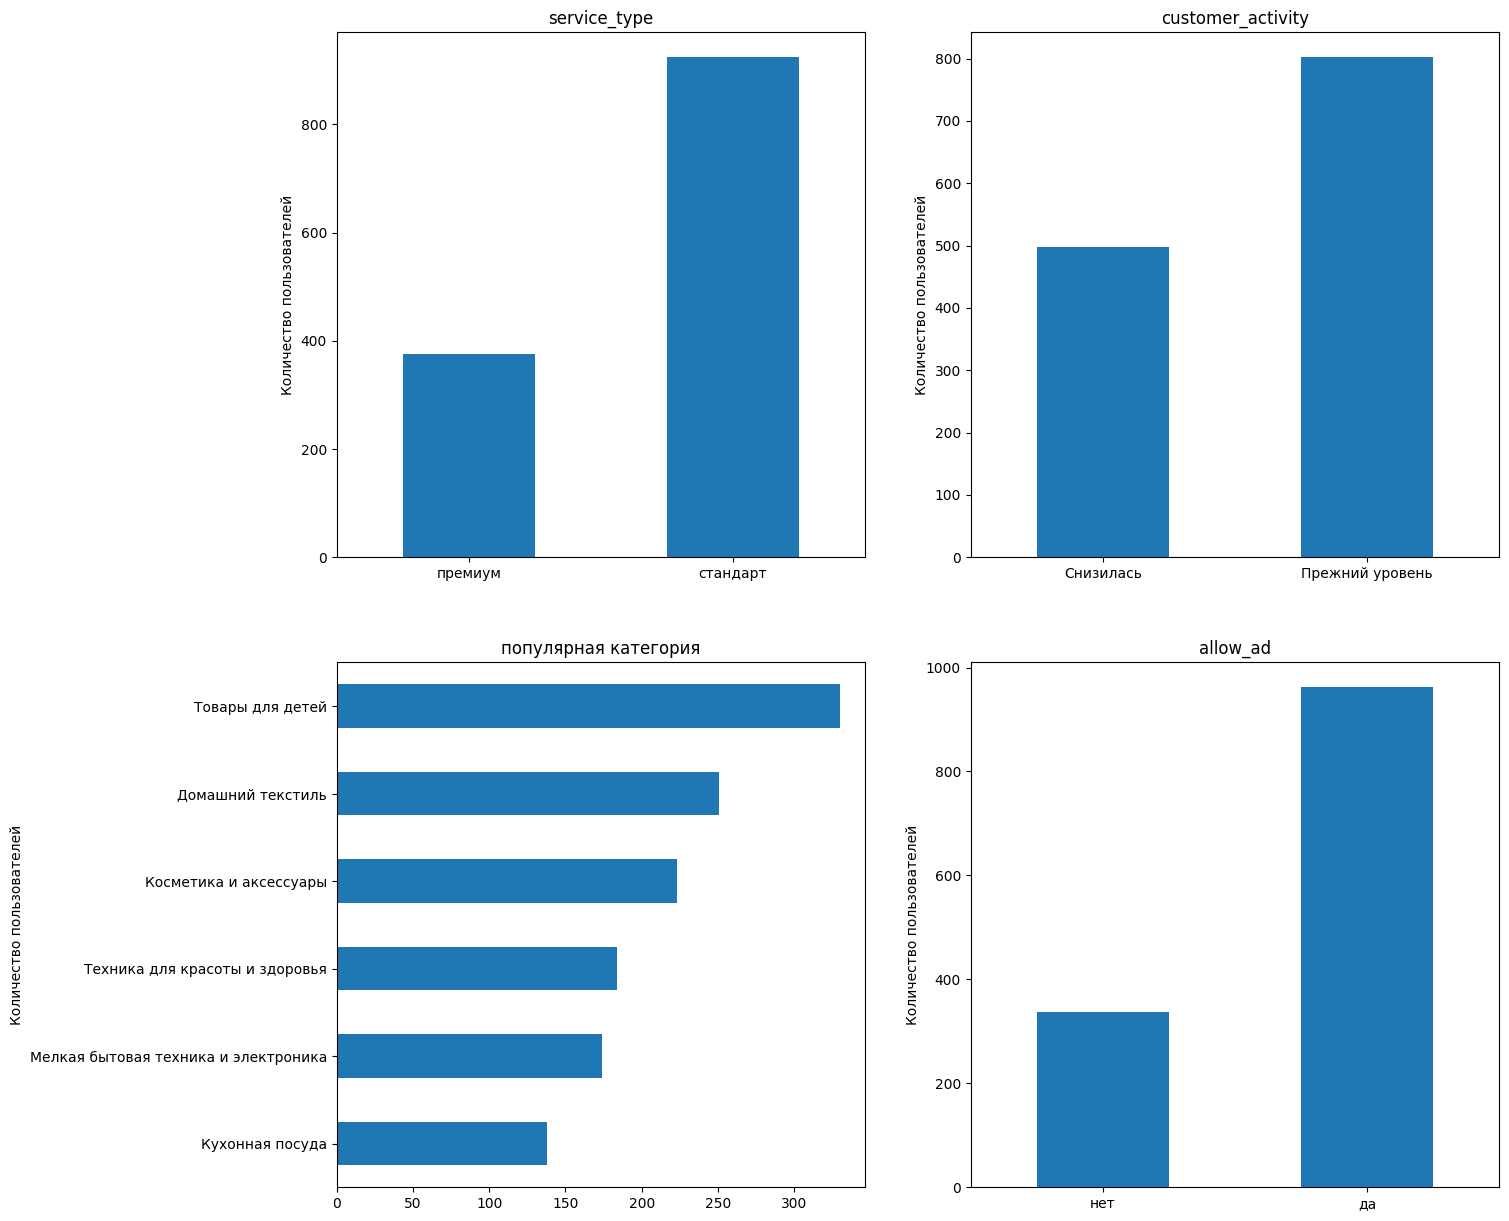

In [111]:
cat_col_names = ['customer_activity',
                 'service_type',
                 'allow_ad']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

for i in range(0, 3):
    show_bar(cat_col_names[i], data_customer, axes[i // 2, 1 - i % 2])

pivot = data_customer['popular_category'].value_counts()
pivot.sort_values(ascending=True, inplace=True)

pivot.plot.barh(title='популярная категория',
                legend='',
                xlabel='',
                ylabel='Количество пользователей',
                rot=0,
                ax=axes[1, 0])

plt.show()

Видно, что пользователи в основном разрешают сообщать об акциях, предпочитают домашний текстиль и товары для детей, пользуются стандартной версией сервиса. Необходимо обратить внимание на дисбаланс классов целевого признака

In [113]:
data_money.head()

period  income
id                                 
215348  препредыдущий_месяц     0.0
215348        текущий_месяц  3293.1
215348     предыдущий_месяц     0.0
215349  препредыдущий_месяц  4472.0
215349        текущий_месяц  4971.6

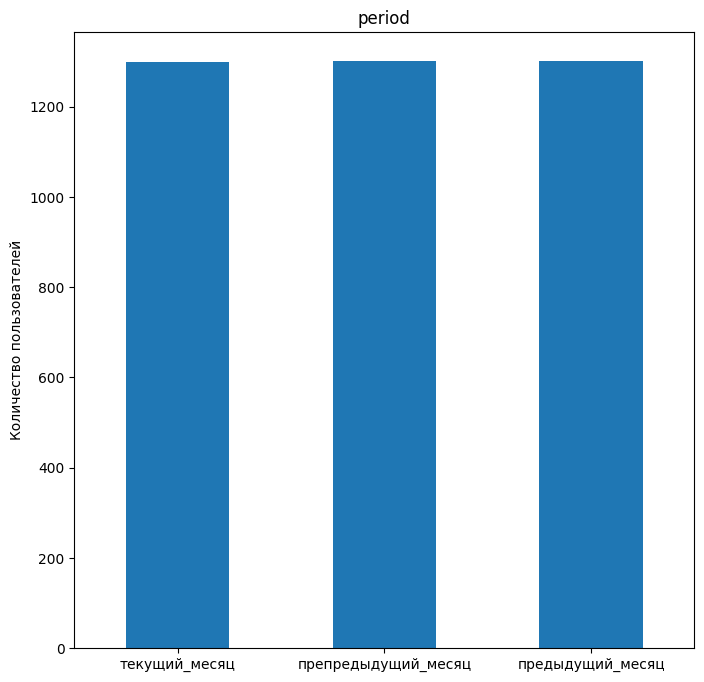

In [114]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
show_bar('period', data_money, axes)
plt.show()

Видим, что данные предоставлены за каждый месяц в одном и том же объеме

In [116]:
data_time.head()

period  minutes
id                               
215348     текущий_месяц       14
215348  предыдущий_месяц       13
215349     текущий_месяц       10
215349  предыдущий_месяц       12
215350     текущий_месяц       13

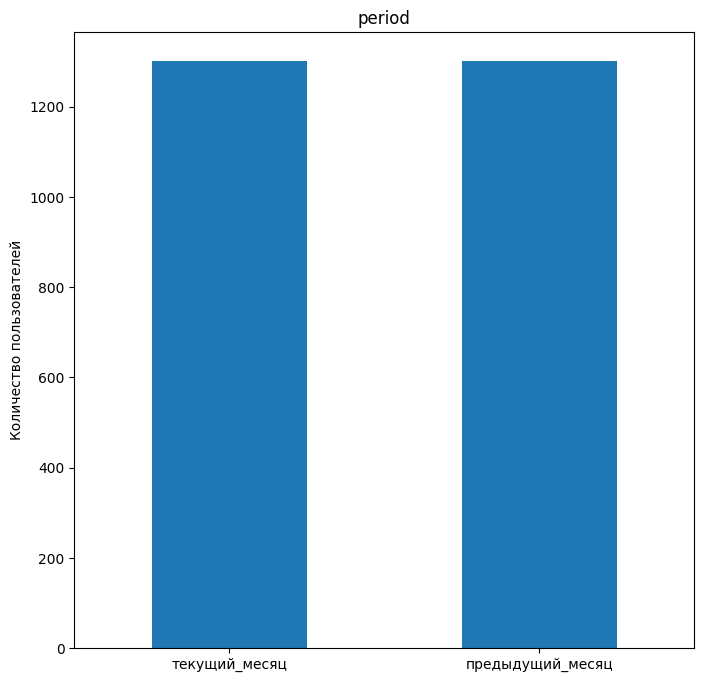

In [117]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
show_bar('period', data_time, axes)
plt.show()

Видим, что данные предоставлены за каждый месяц в одном и том же объеме

In [119]:
data_income.head()

income
id            
215348    0.98
215349    4.16
215350    3.13
215351    4.87
215352    4.21

Тут нет категориальных признаков

Отберем активных пользователей

In [122]:
data_money.head()

period  income
id                                 
215348  препредыдущий_месяц     0.0
215348        текущий_месяц  3293.1
215348     предыдущий_месяц     0.0
215349  препредыдущий_месяц  4472.0
215349        текущий_месяц  4971.6

In [123]:
active_users = data_money[data_money.groupby('id')['income'].prod() > 0]
active_users.head()

period  income
id                                 
215349  препредыдущий_месяц  4472.0
215349        текущий_месяц  4971.6
215349     предыдущий_месяц  5216.0
215350  препредыдущий_месяц  4826.0
215350        текущий_месяц  5058.4

In [124]:
active_users_idx = list(active_users.index)
data_customer['activity_3_months'] = np.where(
    data_customer.index.isin(active_users_idx),
    'да',
    'нет'
)

In [125]:
data_customer.head()

customer_activity service_type allow_ad  ads_6_months  ads_cur_month  \
id                                                                            
215348         Снизилась      премиум       да           3.4              5   
215349         Снизилась      премиум       да           4.4              4   
215350         Снизилась     стандарт      нет           4.9              3   
215351         Снизилась     стандарт       да           3.2              5   
215352         Снизилась     стандарт      нет           5.1              3   

        duration  prom_purchases   popular_category  \
id                                                    
215348       121            0.00   Товары для детей   
215349       819            0.75   Товары для детей   
215350       539            0.14  Домашний текстиль   
215351       896            0.99   Товары для детей   
215352      1064            0.94   Товары для детей   

        mean_category_views_per_visit  unpaid_products_quater  service_error  \
id                                                                             
215348                              6                       2              1   
215349                              4                       4              2   
215350                              5                       2              1   
215351                              5                       0              6   
215352                              3                       2              3   

        pages_per_visit ads_cur_month_cat prom_purchases_cat activity_3_months  
id                                                                              
215348                5           высокий               <70%               нет  
215349                5           средний               >70%                да  
215350                5            низкий               <70%                да  
215351                4           высокий               >70%                да  
215352                2            низкий               >70%                да

In [126]:
data_customer[data_customer['activity_3_months'] == 'нет']

customer_activity service_type allow_ad  ads_6_months  ads_cur_month  \
id                                                                            
215348         Снизилась      премиум       да           3.4              5   
215357         Снизилась     стандарт       да           3.9              5   
215359         Снизилась     стандарт       да           4.6              5   

        duration  prom_purchases                popular_category  \
id                                                                 
215348       121             0.0                Товары для детей   
215357       154             0.0  Техника для красоты и здоровья   
215359       110             0.0               Домашний текстиль   

        mean_category_views_per_visit  unpaid_products_quater  service_error  \
id                                                                             
215348                              6                       2              1   
215357                              3                       3              9   
215359                              4                       2              4   

        pages_per_visit ads_cur_month_cat prom_purchases_cat activity_3_months  
id                                                                              
215348                5           высокий               <70%               нет  
215357                5           высокий               <70%               нет  
215359                2           высокий               <70%               нет

Всего 3 пользователя без активности за 3 месяца

In [128]:
data_customer = data_customer[data_customer['activity_3_months'] == 'да']

In [129]:
data_customer.drop('activity_3_months', axis=1, inplace=True)

In [130]:
data_customer.head()

customer_activity service_type allow_ad  ads_6_months  ads_cur_month  \
id                                                                            
215349         Снизилась      премиум       да           4.4              4   
215350         Снизилась     стандарт      нет           4.9              3   
215351         Снизилась     стандарт       да           3.2              5   
215352         Снизилась     стандарт      нет           5.1              3   
215353         Снизилась     стандарт       да           3.3              4   

        duration  prom_purchases   popular_category  \
id                                                    
215349       819            0.75   Товары для детей   
215350       539            0.14  Домашний текстиль   
215351       896            0.99   Товары для детей   
215352      1064            0.94   Товары для детей   
215353       762            0.26  Домашний текстиль   

        mean_category_views_per_visit  unpaid_products_quater  service_error  \
id                                                                             
215349                              4                       4              2   
215350                              5                       2              1   
215351                              5                       0              6   
215352                              3                       2              3   
215353                              4                       1              1   

        pages_per_visit ads_cur_month_cat prom_purchases_cat  
id                                                            
215349                5           средний               >70%  
215350                5            низкий               <70%  
215351                4           высокий               >70%  
215352                2            низкий               >70%  
215353                4           средний               <70%

По итогам исследовательского анализа данных были добавлены некоторые категориальные признаки, были удалены пользователи без активности за полследние три месяца, удалены вбросы в данных

<a class='anchor' id='fourth-bullet'></a>
## Объединение таблиц

In [133]:
data_time.head()

period  minutes
id                               
215348     текущий_месяц       14
215348  предыдущий_месяц       13
215349     текущий_месяц       10
215349  предыдущий_месяц       12
215350     текущий_месяц       13

In [134]:
data_time_grouped = (
    data_time
      .set_index('period', append=True)  
      ['minutes']
      .unstack(level='period')
      .add_prefix('minutes_')
)

data_time_grouped = data_time_grouped.rename(columns={
    'minutes_предыдущий_месяц': 'minutes_last_month',
    'minutes_текущий_месяц': 'minutes_cur_month'
})
data_time_grouped.head()

period  minutes_last_month  minutes_cur_month
id                                           
215348                  13                 14
215349                  12                 10
215350                   8                 13
215351                  11                 13
215352                   8                 11

In [135]:
data_money.head()

period  income
id                                 
215348  препредыдущий_месяц     0.0
215348        текущий_месяц  3293.1
215348     предыдущий_месяц     0.0
215349  препредыдущий_месяц  4472.0
215349        текущий_месяц  4971.6

In [136]:
data_money_grouped = (
    data_money
      .set_index('period', append=True)  
      ['income']
      .unstack(level='period')
      .add_prefix('income_')
)

data_money_grouped = data_money_grouped.rename(columns={
    'income_предыдущий_месяц': 'income_last_month',
    'income_текущий_месяц': 'income_cur_month',
    'income_препредыдущий_месяц': 'income_2nd_month'
})
data_money_grouped.head()

period  income_last_month  income_2nd_month  income_cur_month
id                                                           
215348                0.0               0.0            3293.1
215349             5216.0            4472.0            4971.6
215350             5457.5            4826.0            5058.4
215351             6158.0            4793.0            6610.4
215352             5807.5            4594.0            5872.5

In [137]:
data_customer.head()

customer_activity service_type allow_ad  ads_6_months  ads_cur_month  \
id                                                                            
215349         Снизилась      премиум       да           4.4              4   
215350         Снизилась     стандарт      нет           4.9              3   
215351         Снизилась     стандарт       да           3.2              5   
215352         Снизилась     стандарт      нет           5.1              3   
215353         Снизилась     стандарт       да           3.3              4   

        duration  prom_purchases   popular_category  \
id                                                    
215349       819            0.75   Товары для детей   
215350       539            0.14  Домашний текстиль   
215351       896            0.99   Товары для детей   
215352      1064            0.94   Товары для детей   
215353       762            0.26  Домашний текстиль   

        mean_category_views_per_visit  unpaid_products_quater  service_error  \
id                                                                             
215349                              4                       4              2   
215350                              5                       2              1   
215351                              5                       0              6   
215352                              3                       2              3   
215353                              4                       1              1   

        pages_per_visit ads_cur_month_cat prom_purchases_cat  
id                                                            
215349                5           средний               >70%  
215350                5            низкий               <70%  
215351                4           высокий               >70%  
215352                2            низкий               >70%  
215353                4           средний               <70%

In [138]:
data = data_customer.join(
    data_time_grouped, on='id', how='left'
).join(
    data_money_grouped, on='id', how='left'
)
data.head()

customer_activity service_type allow_ad  ads_6_months  ads_cur_month  \
id                                                                            
215349         Снизилась      премиум       да           4.4              4   
215350         Снизилась     стандарт      нет           4.9              3   
215351         Снизилась     стандарт       да           3.2              5   
215352         Снизилась     стандарт      нет           5.1              3   
215353         Снизилась     стандарт       да           3.3              4   

        duration  prom_purchases   popular_category  \
id                                                    
215349       819            0.75   Товары для детей   
215350       539            0.14  Домашний текстиль   
215351       896            0.99   Товары для детей   
215352      1064            0.94   Товары для детей   
215353       762            0.26  Домашний текстиль   

        mean_category_views_per_visit  unpaid_products_quater  service_error  \
id                                                                             
215349                              4                       4              2   
215350                              5                       2              1   
215351                              5                       0              6   
215352                              3                       2              3   
215353                              4                       1              1   

        pages_per_visit ads_cur_month_cat prom_purchases_cat  \
id                                                             
215349                5           средний               >70%   
215350                5            низкий               <70%   
215351                4           высокий               >70%   
215352                2            низкий               >70%   
215353                4           средний               <70%   

        minutes_last_month  minutes_cur_month  income_last_month  \
id                                                                 
215349                  12                 10             5216.0   
215350                   8                 13             5457.5   
215351                  11                 13             6158.0   
215352                   8                 11             5807.5   
215353                  10                 10             4738.5   

        income_2nd_month  income_cur_month  
id                                          
215349            4472.0            4971.6  
215350            4826.0            5058.4  
215351            4793.0            6610.4  
215352            4594.0            5872.5  
215353            5124.0            5388.5

In [139]:
print(data_customer.shape)
print(data_money_grouped.shape)
print(data_time_grouped.shape)
print(data.shape)

(1297, 14)
(1300, 3)
(1300, 2)
(1297, 19)


Теперь проверим пропуски

In [141]:
data.isna().sum()

customer_activity                0
service_type                     0
allow_ad                         0
ads_6_months                     0
ads_cur_month                    0
duration                         0
prom_purchases                   0
popular_category                 0
mean_category_views_per_visit    0
unpaid_products_quater           0
service_error                    0
pages_per_visit                  0
ads_cur_month_cat                0
prom_purchases_cat               0
minutes_last_month               0
minutes_cur_month                0
income_last_month                0
income_2nd_month                 0
income_cur_month                 1
dtype: int64

Обнаружен один пропуск: для одного из клиентов не заполнена выручка за текущий месяц. Удалим его, так как скорее всего его активность на сайте меньше трех месяцев

In [143]:
data = data.dropna()

In [144]:
data.isna().sum()

customer_activity                0
service_type                     0
allow_ad                         0
ads_6_months                     0
ads_cur_month                    0
duration                         0
prom_purchases                   0
popular_category                 0
mean_category_views_per_visit    0
unpaid_products_quater           0
service_error                    0
pages_per_visit                  0
ads_cur_month_cat                0
prom_purchases_cat               0
minutes_last_month               0
minutes_cur_month                0
income_last_month                0
income_2nd_month                 0
income_cur_month                 0
dtype: int64

В процессе объединения таблиц был создан единый датасет для работы с информацией о пользователях на сайте

<a class='anchor' id='fifth-bullet'></a>
## Корреляционный анализ

In [147]:
data.columns

Index(['customer_activity', 'service_type', 'allow_ad', 'ads_6_months',
       'ads_cur_month', 'duration', 'prom_purchases', 'popular_category',
       'mean_category_views_per_visit', 'unpaid_products_quater',
       'service_error', 'pages_per_visit', 'ads_cur_month_cat',
       'prom_purchases_cat', 'minutes_last_month', 'minutes_cur_month',
       'income_last_month', 'income_2nd_month', 'income_cur_month'],
      dtype='object')

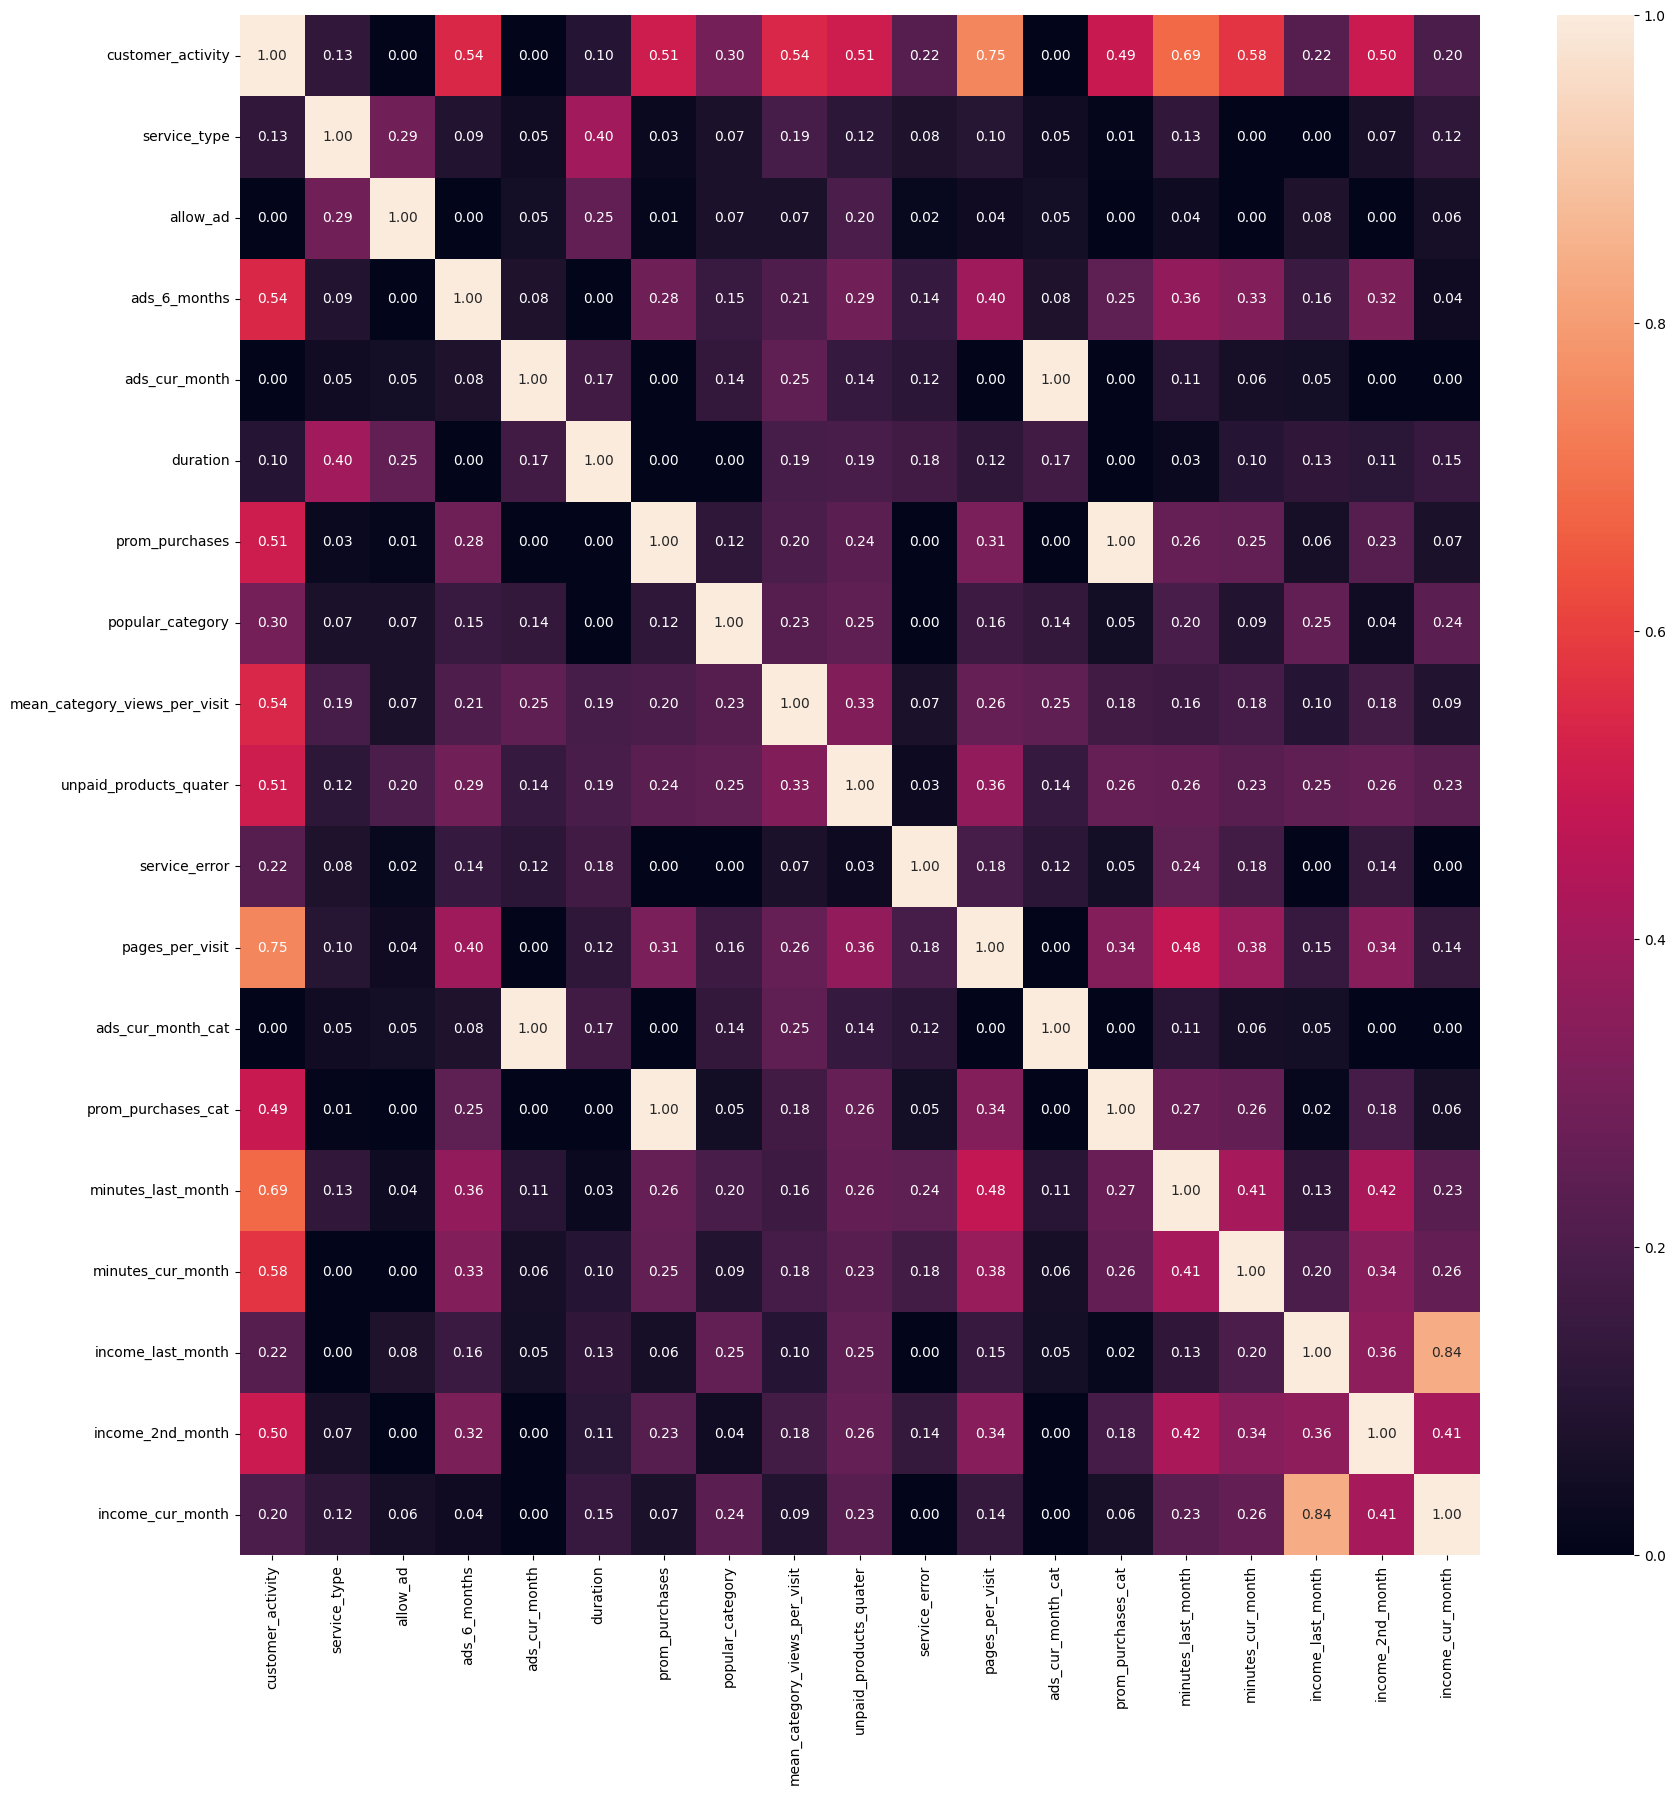

In [148]:
interval_cols = {
    'ads_6_months',
    'ads_cur_month',
    'duration',
    'prom_purchases',
    'mean_category_views_per_visit',
    'unpaid_products_quater',
    'service_error',
    'pages_per_visit',
    'minutes_last_month',
    'minutes_cur_month',
    'income_last_month',
    'income_2nd_month',
    'income_cur_month'
}

plt.figure(figsize=(20, 20))

sns.heatmap(
    data.phik_matrix(
        interval_cols=interval_cols
    ), annot=True, fmt='.2f'
)

plt.show()

Примем, что линейно корреллирующие признаки имеют коэффициент корреляции >= 20. Глядя на матрицу, можно увидеть, что линейно коррелирующими признаками являются следующие

In [150]:
linear_corr_cols = [
    'ads_6_months',
    'prom_purchases',
    'popular_category',
    'mean_category_views_per_visit',
    'unpaid_products_quater',
    'service_error',
    'pages_per_visit',
    'prom_purchases_cat',
    'minutes_last_month',
    'minutes_cur_month',
    'income_last_month',
    'income_2nd_month',
    'income_cur_month'
]

Удалим из таблицы некоррелирующие признаки

In [152]:
linear_corr_cols.insert(0, 'customer_activity')

In [153]:
data_cor = data[linear_corr_cols]
data_cor.head()

customer_activity  ads_6_months  prom_purchases   popular_category  \
id                                                                          
215349         Снизилась           4.4            0.75   Товары для детей   
215350         Снизилась           4.9            0.14  Домашний текстиль   
215351         Снизилась           3.2            0.99   Товары для детей   
215352         Снизилась           5.1            0.94   Товары для детей   
215353         Снизилась           3.3            0.26  Домашний текстиль   

        mean_category_views_per_visit  unpaid_products_quater  service_error  \
id                                                                             
215349                              4                       4              2   
215350                              5                       2              1   
215351                              5                       0              6   
215352                              3                       2              3   
215353                              4                       1              1   

        pages_per_visit prom_purchases_cat  minutes_last_month  \
id                                                               
215349                5               >70%                  12   
215350                5               <70%                   8   
215351                4               >70%                  11   
215352                2               >70%                   8   
215353                4               <70%                  10   

        minutes_cur_month  income_last_month  income_2nd_month  \
id                                                               
215349                 10             5216.0            4472.0   
215350                 13             5457.5            4826.0   
215351                 13             6158.0            4793.0   
215352                 11             5807.5            4594.0   
215353                 10             4738.5            5124.0   

        income_cur_month  
id                        
215349            4971.6  
215350            5058.4  
215351            6610.4  
215352            5872.5  
215353            5388.5

Построим матрицу корреляций еще раз

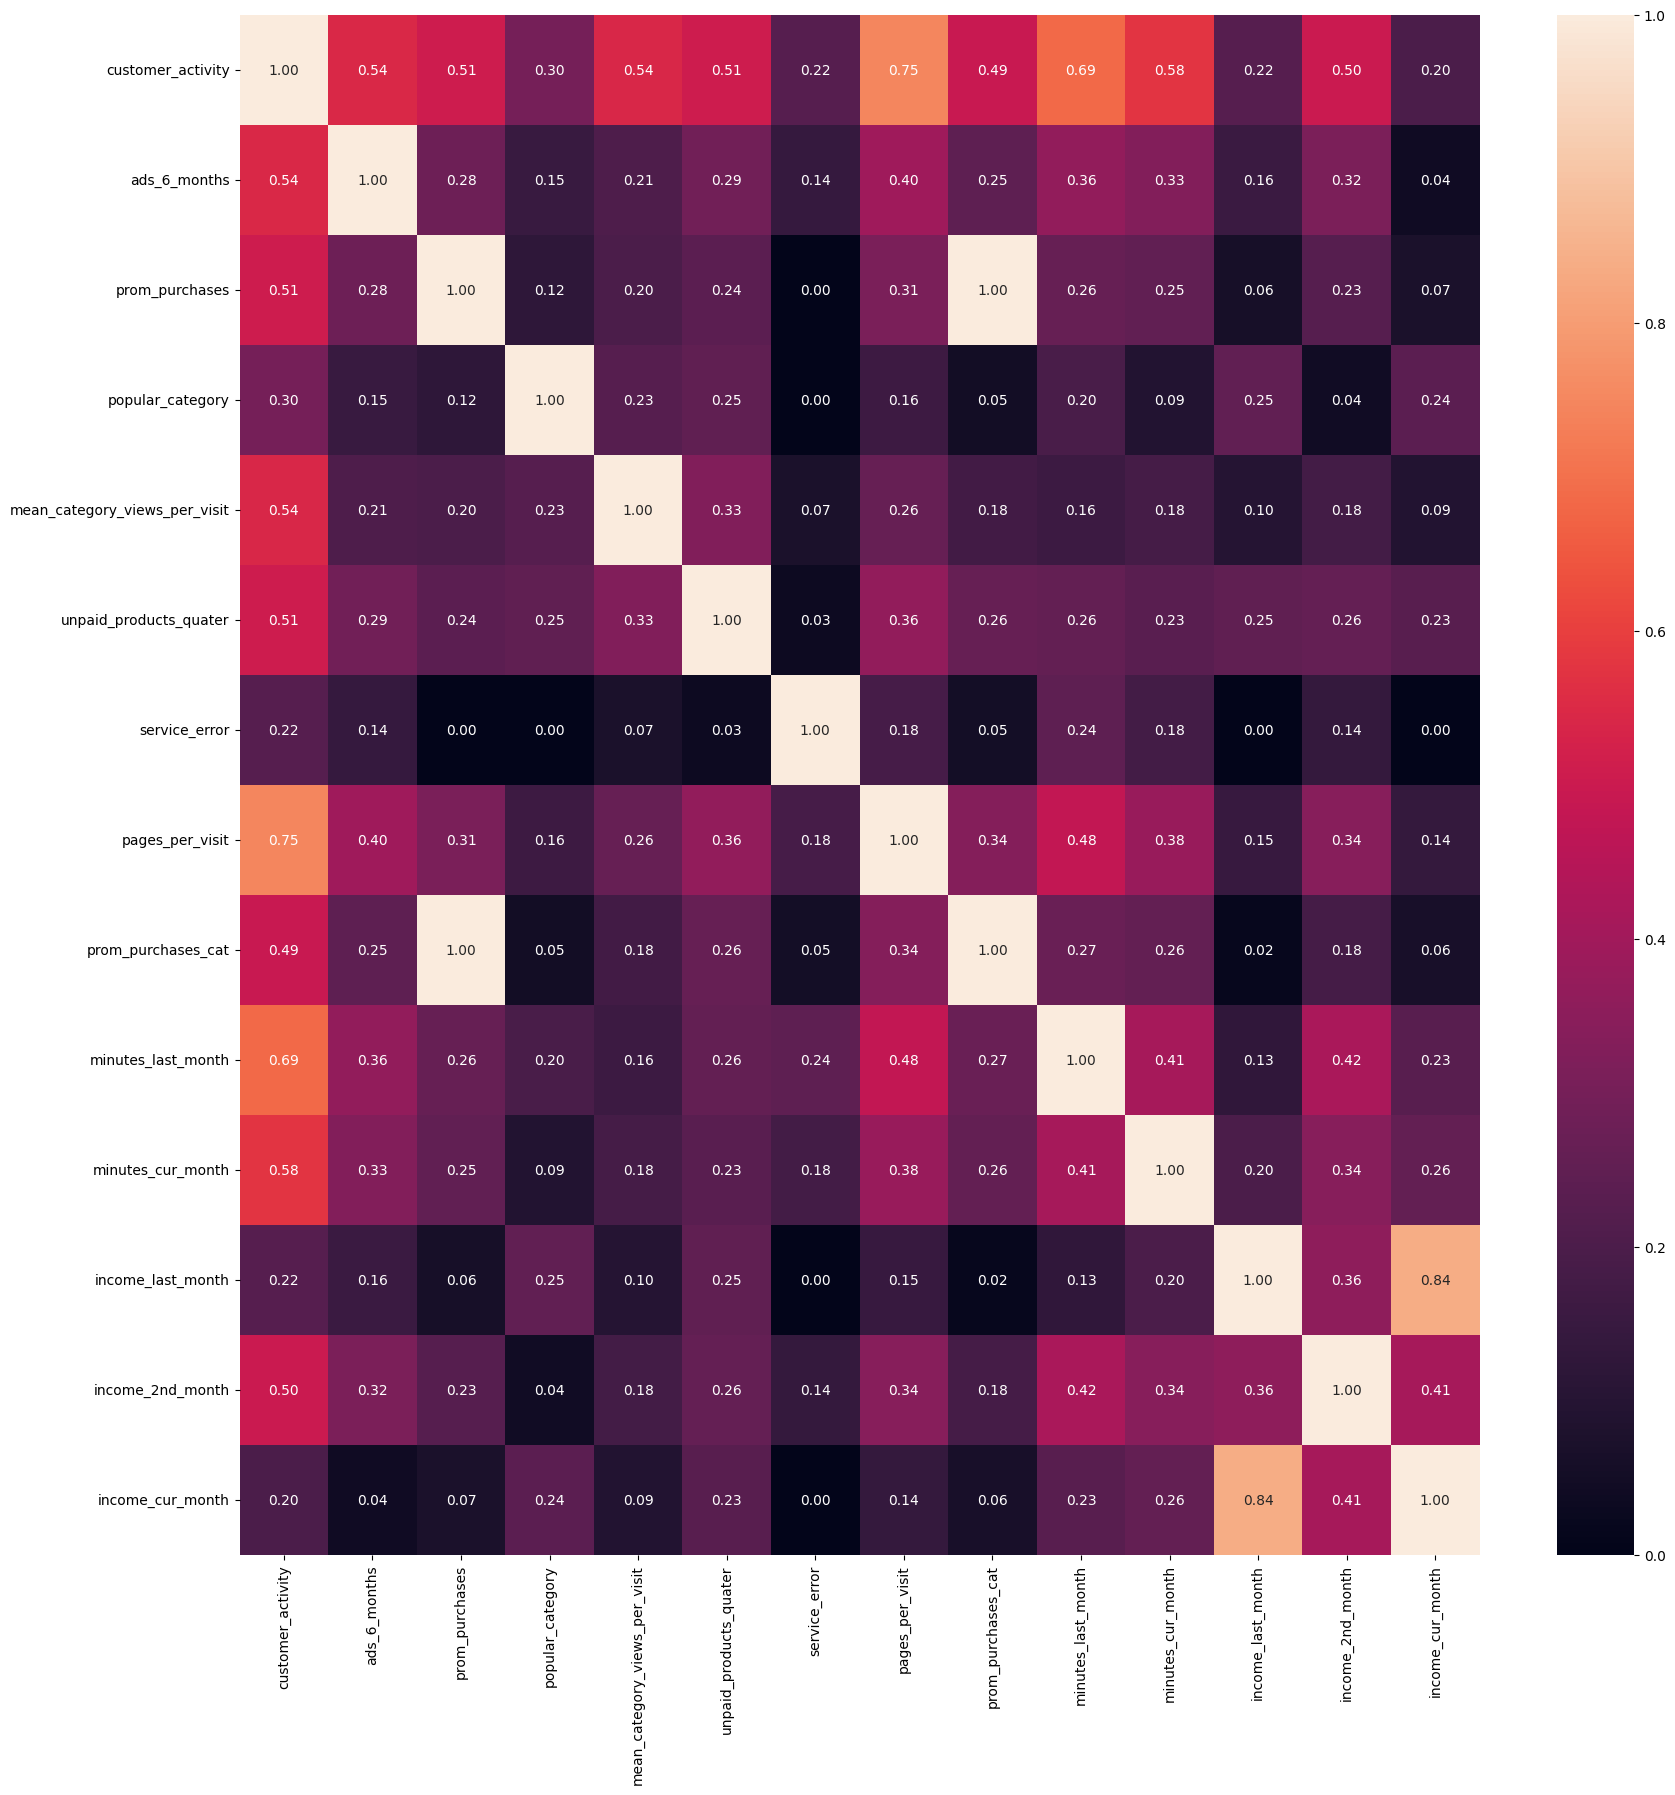

In [155]:
interval_cols = {
    'ads_6_months',
    'duration',
    'prom_purchases',
    'mean_category_views_per_visit',
    'unpaid_products_quater',
    'service_error',
    'pages_per_visit',
    'minutes_last_month',
    'minutes_cur_month',
    'income_last_month',
    'income_2nd_month',
    'income_cur_month'
}

plt.figure(figsize=(20, 20))

sns.heatmap(
    data_cor.phik_matrix(
        interval_cols=interval_cols
    ), annot=True, fmt='.2f'
)

plt.show()

Удалим сильно коррелиющий признак `prom_purchases`, оставив только `prom_purchases_cat`. 

In [157]:
data_cor = data_cor.drop(['prom_purchases'], axis=1)

In [158]:
data_cor.head()

customer_activity  ads_6_months   popular_category  \
id                                                          
215349         Снизилась           4.4   Товары для детей   
215350         Снизилась           4.9  Домашний текстиль   
215351         Снизилась           3.2   Товары для детей   
215352         Снизилась           5.1   Товары для детей   
215353         Снизилась           3.3  Домашний текстиль   

        mean_category_views_per_visit  unpaid_products_quater  service_error  \
id                                                                             
215349                              4                       4              2   
215350                              5                       2              1   
215351                              5                       0              6   
215352                              3                       2              3   
215353                              4                       1              1   

        pages_per_visit prom_purchases_cat  minutes_last_month  \
id                                                               
215349                5               >70%                  12   
215350                5               <70%                   8   
215351                4               >70%                  11   
215352                2               >70%                   8   
215353                4               <70%                  10   

        minutes_cur_month  income_last_month  income_2nd_month  \
id                                                               
215349                 10             5216.0            4472.0   
215350                 13             5457.5            4826.0   
215351                 13             6158.0            4793.0   
215352                 11             5807.5            4594.0   
215353                 10             4738.5            5124.0   

        income_cur_month  
id                        
215349            4971.6  
215350            5058.4  
215351            6610.4  
215352            5872.5  
215353            5388.5

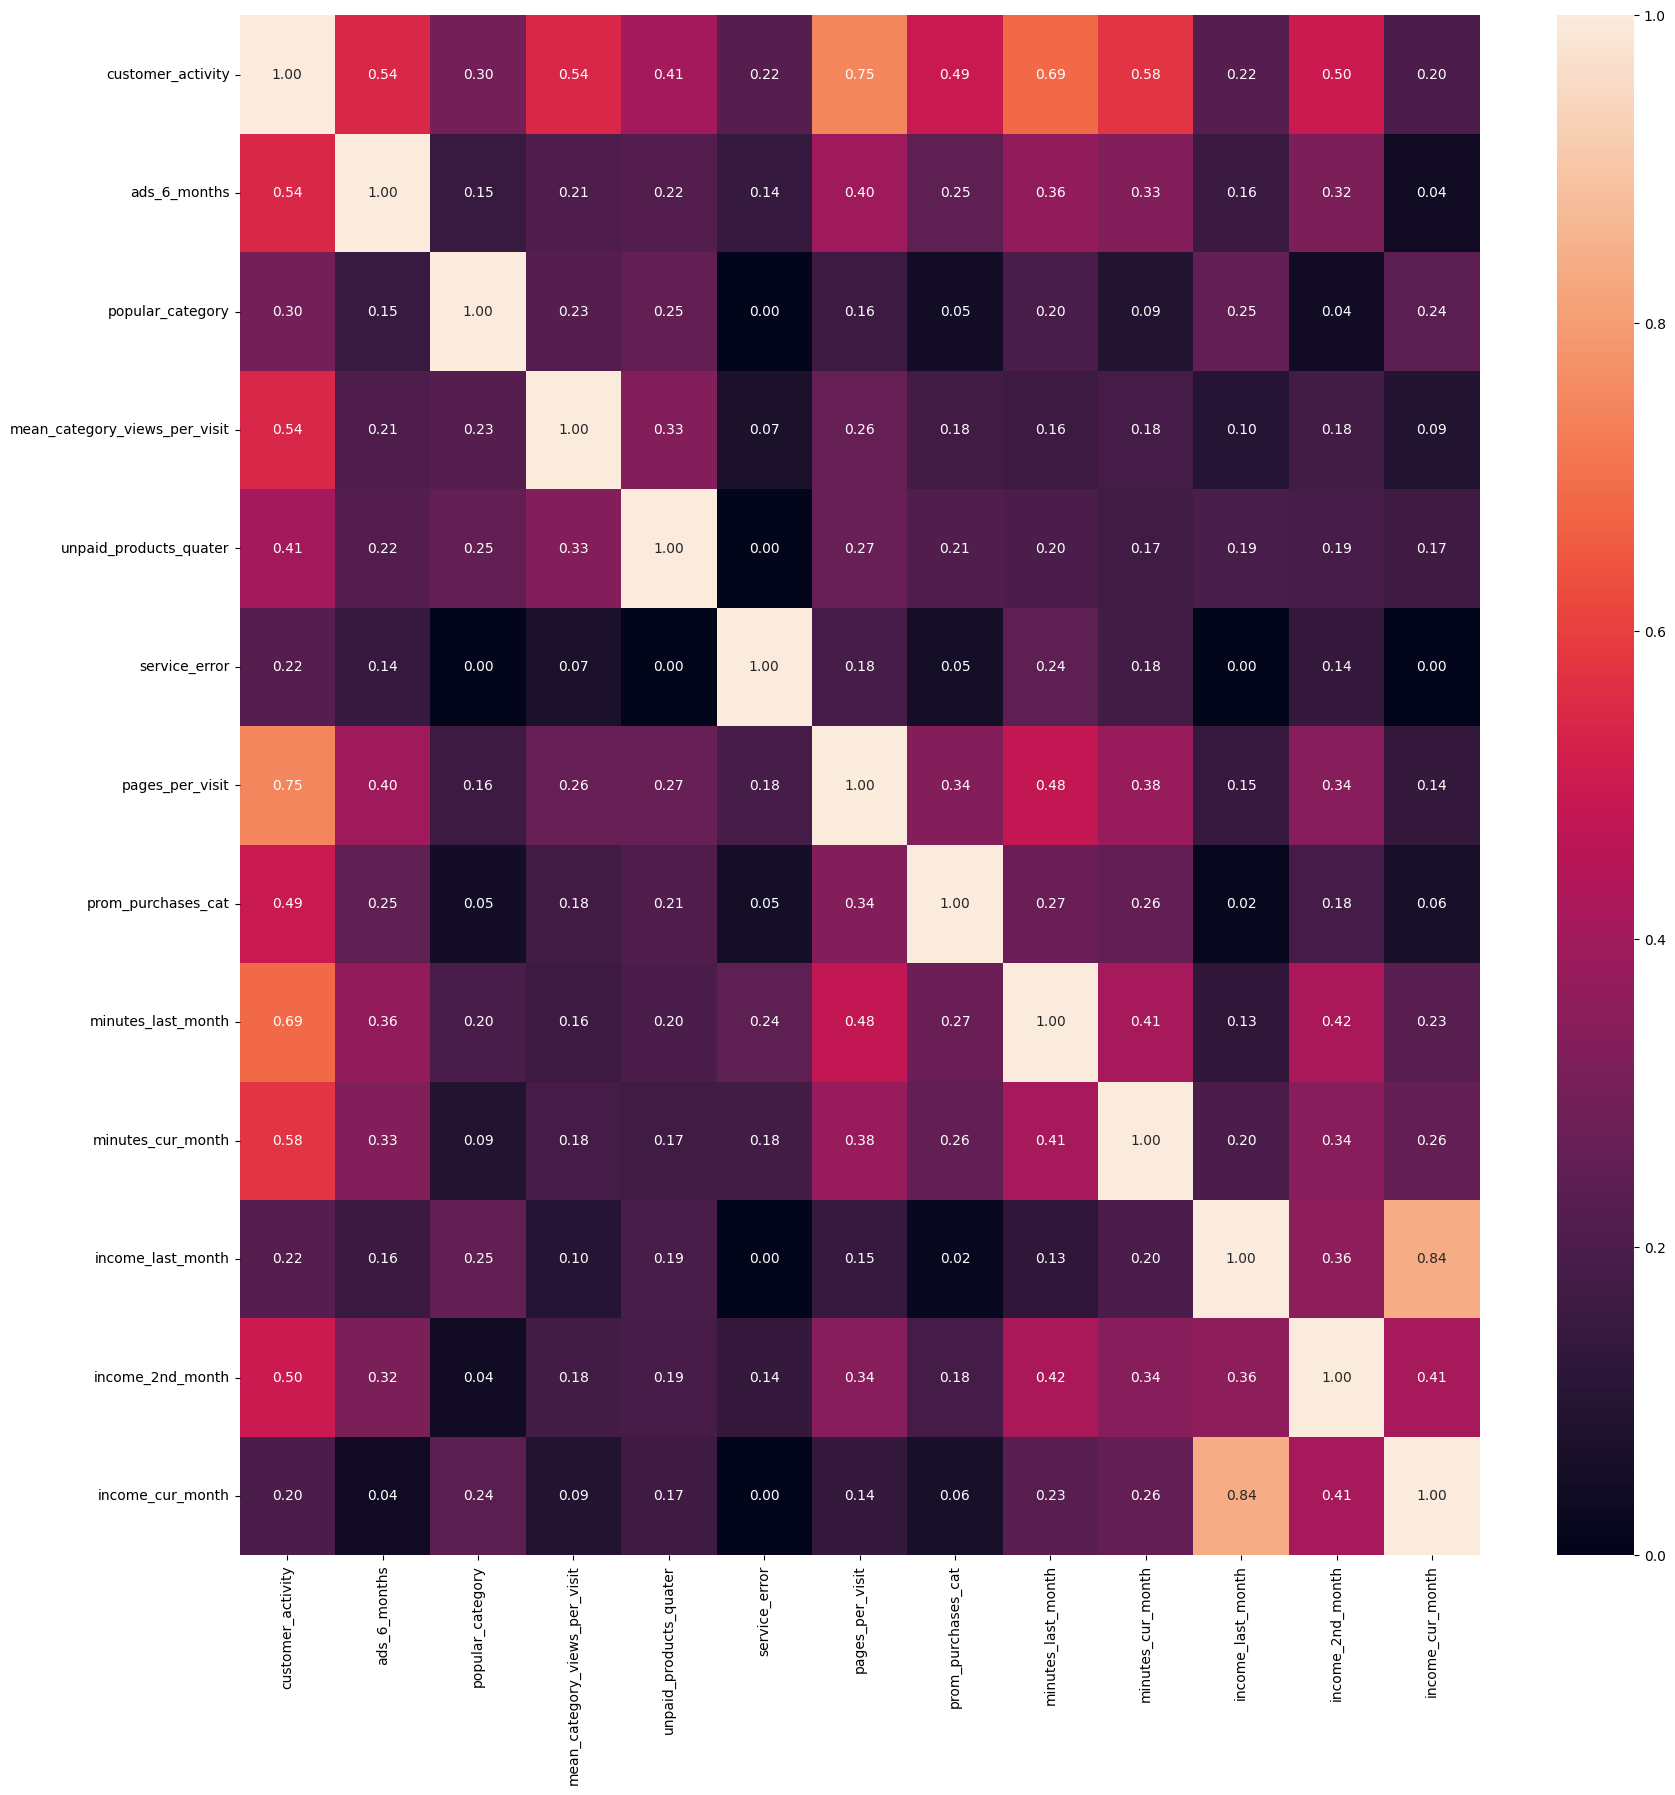

In [159]:
interval_cols = {
    'ads_6_months',
    'mean_category_views_per_visit',
    'service_error',
    'pages_per_visit',
    'minutes_last_month',
    'minutes_cur_month',
    'income_last_month',
    'income_2nd_month',
    'income_cur_month'
}

plt.figure(figsize=(20, 20))

sns.heatmap(
    data_cor.phik_matrix(
        interval_cols=interval_cols
    ), annot=True, fmt='.2f'
)

plt.show()

Есть определенная категория пользователей, которая приходит на сайт, долго его листает и кладет в корзину товары, которые в итоге не заказывает. При этом маркетинговые коммуникации с такими пользователями происходят достаточно часто.

In [161]:
data_cor.head()

customer_activity  ads_6_months   popular_category  \
id                                                          
215349         Снизилась           4.4   Товары для детей   
215350         Снизилась           4.9  Домашний текстиль   
215351         Снизилась           3.2   Товары для детей   
215352         Снизилась           5.1   Товары для детей   
215353         Снизилась           3.3  Домашний текстиль   

        mean_category_views_per_visit  unpaid_products_quater  service_error  \
id                                                                             
215349                              4                       4              2   
215350                              5                       2              1   
215351                              5                       0              6   
215352                              3                       2              3   
215353                              4                       1              1   

        pages_per_visit prom_purchases_cat  minutes_last_month  \
id                                                               
215349                5               >70%                  12   
215350                5               <70%                   8   
215351                4               >70%                  11   
215352                2               >70%                   8   
215353                4               <70%                  10   

        minutes_cur_month  income_last_month  income_2nd_month  \
id                                                               
215349                 10             5216.0            4472.0   
215350                 13             5457.5            4826.0   
215351                 13             6158.0            4793.0   
215352                 11             5807.5            4594.0   
215353                 10             4738.5            5124.0   

        income_cur_month  
id                        
215349            4971.6  
215350            5058.4  
215351            6610.4  
215352            5872.5  
215353            5388.5

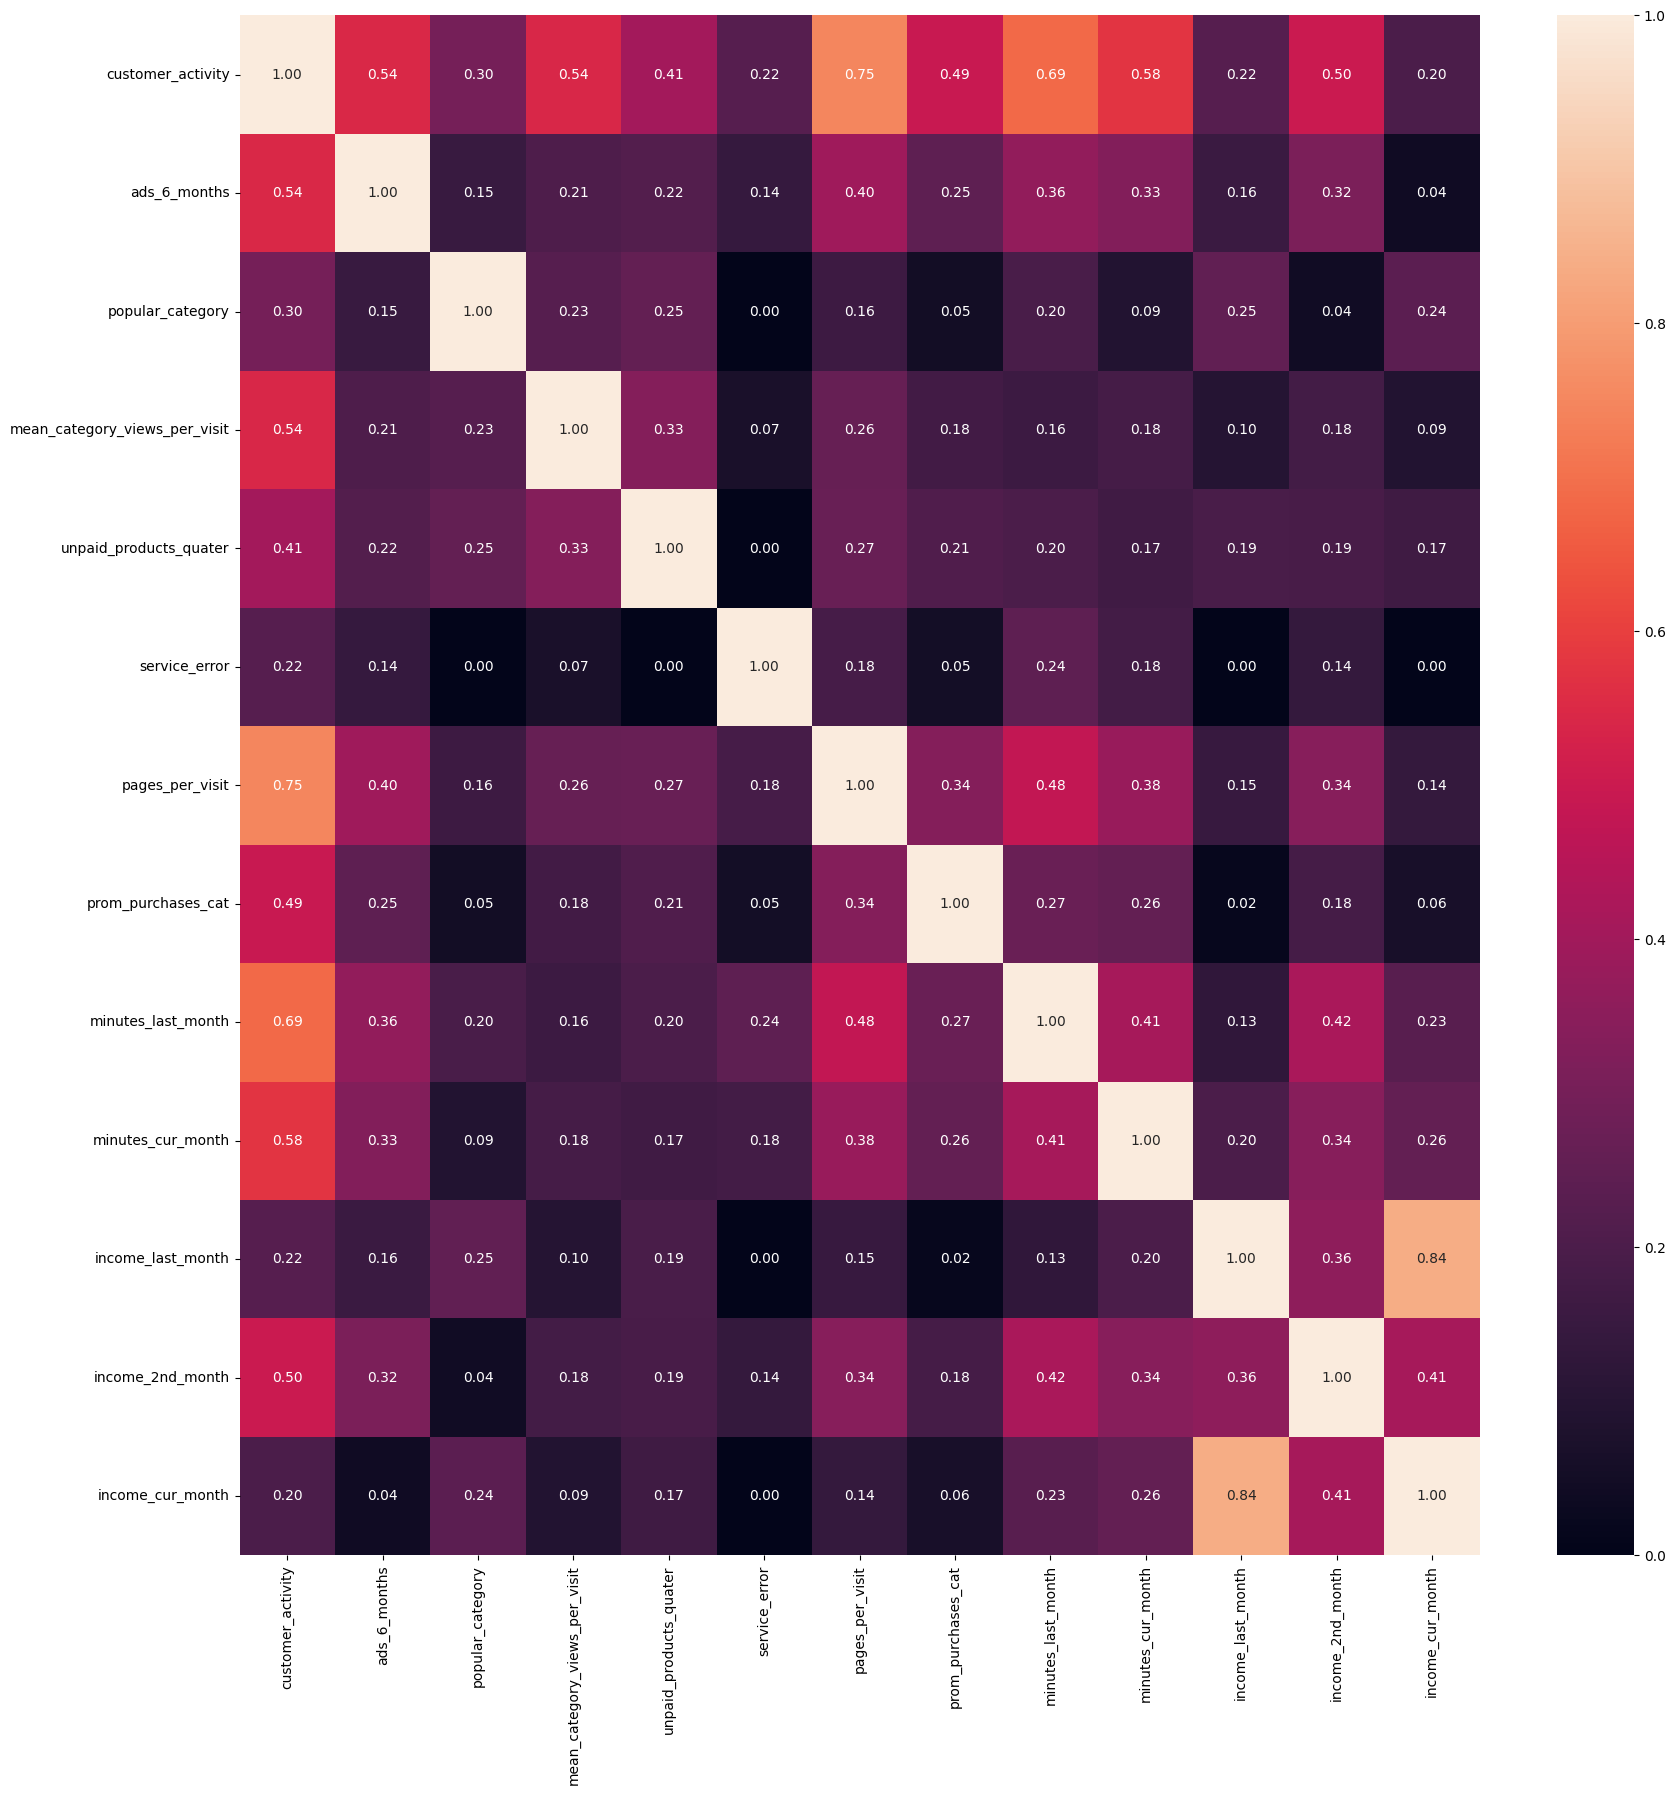

In [162]:
interval_cols = {
    'ads_6_months',
    'mean_category_views_per_visit',
    'service_error',
    'pages_per_visit',
    'minutes_last_month',
    'minutes_cur_month',
    'income_2nd_month',
    'income_last_month',
    'income_cur_month'
}

plt.figure(figsize=(20, 20))

sns.heatmap(
    data_cor.phik_matrix(
        interval_cols=interval_cols
    ), annot=True, fmt='.2f'
)

plt.show()

В процессе корреляционного анализа из датасета были отброшены признаки, слабо коррелирующие с целевым. Кроме того, была устранена мультиколлинеарность, а также были удалены данные, способные создать помехи.

Более того, было выявлено, что существует категория клиентов, которая приходит на сайт, долго его листает и кладет в корзину товары, которые в итоге не заказывает. При этом маркетинговые коммуникации с такими пользователями происходят достаточно часто.

<a class='anchor' id='sixth-bullet'></a>
## Использование пайплайнов

In [165]:
X_train, X_test, y_train, y_test = train_test_split(
    data_cor.drop(['customer_activity'], axis=1),
    data_cor['customer_activity'],
    stratify=data_cor['customer_activity'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((972, 12), (324, 12))

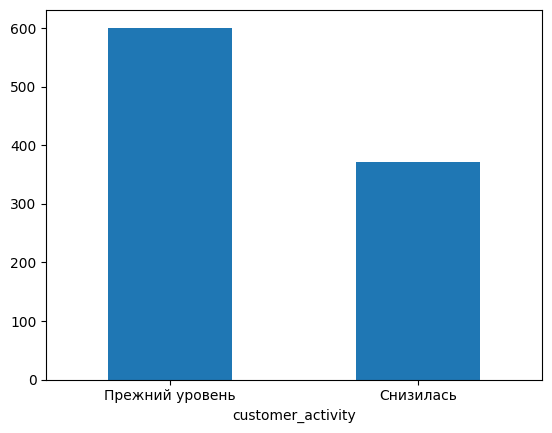

In [166]:
y_train.value_counts().plot(kind='bar', rot=0)
plt.show()

Можно увидеть, что значение `снизилась` встречается ощутимо реже. Тем не менее, на данном этапе устранять дисбаланс нет смысла, так как в пайплайнах будет происходить кросс-валидация, а сэмплирование валидационных данных приведет к завышению оценки качества модели

In [168]:
X_train.head()

ads_6_months                      popular_category  \
id                                                           
215858           5.5  Мелкая бытовая техника и электроника   
215361           5.1        Техника для красоты и здоровья   
215884           4.3  Мелкая бытовая техника и электроника   
216564           5.6                       Кухонная посуда   
215715           3.6                      Товары для детей   

        mean_category_views_per_visit  unpaid_products_quater  service_error  \
id                                                                             
215858                              2                       4              7   
215361                              4                       5              2   
215884                              5                       1              3   
216564                              2                       7              5   
215715                              3                       2              2   

        pages_per_visit prom_purchases_cat  minutes_last_month  \
id                                                               
215858               16               <70%                  20   
215361                3               <70%                  11   
215884               11               <70%                  13   
216564                8               >70%                  14   
215715                5               <70%                  10   

        minutes_cur_month  income_last_month  income_2nd_month  \
id                                                               
215858                  6             5170.5            4347.0   
215361                 13             6400.0            4597.0   
215884                 10             4113.0            4626.0   
216564                 19             4930.0            5269.0   
215715                 10             3716.0            4691.0   

        income_cur_month  
id                        
215858            6014.2  
215361            3789.7  
215884            3798.4  
216564            4766.2  
215715            4600.0

In [169]:
ohe_columns = [
    'popular_category'
]

ord_columns = [
    'prom_purchases_cat'
]

num_columns = [
    'ads_6_months',
    'mean_category_views_per_visit',
    'unpaid_products_quater',
    'service_error',
    'pages_per_visit',
    'minutes_last_month',
    'minutes_cur_month',
    'income_2nd_month',
    'income_last_month',
    'income_cur_month'
]

In [170]:
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

In [171]:
import sklearn
sklearn.__version__

'1.6.1'

In [172]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['<70%', '>70%']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [173]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(2))
])

In [174]:
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', num_pipe, num_columns)
], remainder='passthrough')

In [175]:
cat_cols = ohe_columns + ord_columns
cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]
over = SMOTETomek(
    sampling_strategy=0.7,
    smote=SMOTENC(categorical_features=cat_idx, random_state=RANDOM_STATE),
    tomek=TomekLinks(),
    random_state=RANDOM_STATE
)

In [176]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('over', over),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

Создадим словарь перебора гиперпараметров

In [178]:
param_grid = [
    {
      'over__smote__k_neighbors': distributions.IntDistribution(2, 7),
      'models': CategoricalDistribution([KNeighborsClassifier()]),
      'models__n_neighbors': IntDistribution(1, 15),
      'models__weights': CategoricalDistribution(['uniform','distance']),
      'models__metric': CategoricalDistribution(['minkowski','manhattan']),
      'models__p': CategoricalDistribution([1,2]),
      'preprocessor__num__scaler': CategoricalDistribution([StandardScaler(),MinMaxScaler(),'passthrough'])
    },
    {
      'over__smote__k_neighbors': distributions.IntDistribution(2, 7),
      'models': CategoricalDistribution([DecisionTreeClassifier(random_state=RANDOM_STATE)]),
      'models__criterion': CategoricalDistribution(['gini','entropy']),
      'models__max_depth': IntDistribution(3, 20),
      'models__min_samples_split': IntDistribution(2, 10),
      'models__min_samples_leaf': IntDistribution(1, 5),
      'models__class_weight': CategoricalDistribution(['balanced',None]),
      'preprocessor__num__scaler': CategoricalDistribution([StandardScaler(),MinMaxScaler(),'passthrough'])
    },
    {
      'over__smote__k_neighbors': distributions.IntDistribution(2, 7),
      'models': CategoricalDistribution([LogisticRegression(random_state=RANDOM_STATE, solver='saga', max_iter=5000)]),
      'models__penalty': CategoricalDistribution(['l1','l2','elasticnet']),
      'models__l1_ratio': distributions.FloatDistribution(low=0.0, high=1.0, step=0.2),
      'models__C': distributions.FloatDistribution(low=1e-3, high=1e3, log=True),
      'models__class_weight': CategoricalDistribution(['balanced',None]),
      'preprocessor__num__scaler': CategoricalDistribution([StandardScaler(),MinMaxScaler(),'passthrough'])
    },
    {
      'over__smote__k_neighbors': distributions.IntDistribution(2, 7),
      'models': distributions.CategoricalDistribution([SVC(probability=True, random_state=RANDOM_STATE)]),
        'models__kernel': distributions.CategoricalDistribution(['rbf', 'sigmoid', 'poly']),
        'models__degree': distributions.IntDistribution(1, 6),
        'preprocessor__num__scaler': distributions.CategoricalDistribution([StandardScaler(), MinMaxScaler(), 'passthrough'])
    }
]

Настраиваем инструмент поиска лучшей модели. Возьмем OptunaSearchCV для ускорения поиска. Используем метрику f1, так как важны как precision, так и recall, и есть дисбаланс классов

In [180]:
def get_search(params):
    return OptunaSearchCV(
        pipe_final,
        params,
        cv=5,
        scoring='f1',
        n_trials=100,
        random_state=RANDOM_STATE,
        error_score=0.0,
        n_jobs=-1,
        verbose=2
    )

In [181]:
search_neighbors = get_search(param_grid[0])
search_tree = get_search(param_grid[1])
search_logistic = get_search(param_grid[2])
search_svc = get_search(param_grid[3])

/var/folders/72/fvkccqv51k3g5smc3bsp9x500000gn/T/ipykernel_86773/4138289685.py:2: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  return OptunaSearchCV(


Закодируем целевой признак

In [183]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [184]:
search_neighbors.fit(X_train, y_train)

[I 2025-08-01 21:43:57,523] A new study created in memory with name: no-name-e7e2db3d-1f0d-4359-9356-1fc4a1a12e9f
[I 2025-08-01 21:43:59,190] Trial 6 finished with value: 0.7940124702944431 and parameters: {'over__smote__k_neighbors': 3, 'models': KNeighborsClassifier(metric='manhattan', n_neighbors=6, p=1), 'models__n_neighbors': 12, 'models__weights': 'distance', 'models__metric': 'manhattan', 'models__p': 2, 'preprocessor__num__scaler': MinMaxScaler()}. Best is trial 6 with value: 0.7940124702944431.
[I 2025-08-01 21:43:59,264] Trial 2 finished with value: 0.5988368684626365 and parameters: {'over__smote__k_neighbors': 2, 'models': KNeighborsClassifier(metric='manhattan', n_neighbors=9, p=1, weights='distance'), 'models__n_neighbors': 15, 'models__weights': 'distance', 'models__metric': 'minkowski', 'models__p': 2, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.7940124702944431.
[I 2025-08-01 21:43:59,267] Trial 4 finished with value: 0.5956199033418236 a

OptunaSearchCV(cv=5, error_score=0.0,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ohe',
                                                                           Pipeline(steps=[('simpleImputer_ohe',
                                                                                            SimpleImputer(strategy='most_frequent')),
                                                                                           ('ohe',
                                                                                            OneHotEncoder(drop='first',
                                                                                                          handle_unknown='ignore',
                                                                                                          sparse_output=False))]),
                                                                           ['popular_category']),
                                                                          ('ord',
                                                                           Pipeline(steps=[('si...
                                    'models__n_neighbors': IntDistribution(high=15, log=False, low=1, step=1),
                                    'models__p': CategoricalDistribution(choices=(1, 2)),
                                    'models__weights': CategoricalDistribution(choices=('uniform', 'distance')),
                                    'over__smote__k_neighbors': IntDistribution(high=7, log=False, low=2, step=1),
                                    'preprocessor__num__scaler': CategoricalDistribution(choices=(StandardScaler(), MinMaxScaler(), 'passthrough'))},
               random_state=42, scoring='f1', verbose=2)

In [185]:
search_tree.fit(X_train, y_train)

[I 2025-08-01 21:44:17,183] A new study created in memory with name: no-name-3414a802-b68c-49c8-b106-93b89057d3b8
[I 2025-08-01 21:44:18,609] Trial 6 finished with value: 0.7695792504011683 and parameters: {'over__smote__k_neighbors': 5, 'models': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=16, min_samples_leaf=2, random_state=42), 'models__criterion': 'entropy', 'models__max_depth': 19, 'models__min_samples_split': 6, 'models__min_samples_leaf': 1, 'models__class_weight': None, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.7695792504011683.
[I 2025-08-01 21:44:18,615] Trial 1 finished with value: 0.7465494368344487 and parameters: {'over__smote__k_neighbors': 6, 'models': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, min_samples_leaf=4, min_samples_split=4,
                       random_state=42), 'models__criterion': 'gini', 'models__max_d

OptunaSearchCV(cv=5, error_score=0.0,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ohe',
                                                                           Pipeline(steps=[('simpleImputer_ohe',
                                                                                            SimpleImputer(strategy='most_frequent')),
                                                                                           ('ohe',
                                                                                            OneHotEncoder(drop='first',
                                                                                                          handle_unknown='ignore',
                                                                                                          sparse_output=False))]),
                                                                           ['popular_category']),
                                                                          ('ord',
                                                                           Pipeline(steps=[('si...
                                    'models__min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1),
                                    'models__min_samples_split': IntDistribution(high=10, log=False, low=2, step=1),
                                    'over__smote__k_neighbors': IntDistribution(high=7, log=False, low=2, step=1),
                                    'preprocessor__num__scaler': CategoricalDistribution(choices=(StandardScaler(), MinMaxScaler(), 'passthrough'))},
               random_state=42, scoring='f1', verbose=2)

In [186]:
search_logistic.fit(X_train, y_train)

[I 2025-08-01 21:44:36,462] A new study created in memory with name: no-name-caff2071-3091-4bf6-a641-50a72fcdb1e8
[I 2025-08-01 21:44:37,838] Trial 6 finished with value: 0.8004536971940144 and parameters: {'over__smote__k_neighbors': 5, 'models': LogisticRegression(C=0.37559564482162544, class_weight='balanced', l1_ratio=0.4,
                   max_iter=5000, penalty='elasticnet', random_state=42,
                   solver='saga'), 'models__penalty': 'l1', 'models__l1_ratio': 1.0, 'models__C': 739.9095482731793, 'models__class_weight': 'balanced', 'preprocessor__num__scaler': MinMaxScaler()}. Best is trial 6 with value: 0.8004536971940144.
[I 2025-08-01 21:44:40,784] Trial 2 finished with value: 0.8026179976534342 and parameters: {'over__smote__k_neighbors': 2, 'models': LogisticRegression(C=28.07986270384903, class_weight='balanced', l1_ratio=1.0,
                   max_iter=5000, penalty='elasticnet', random_state=42,
                   solver='saga'), 'models__penalty': 'elasticnet

OptunaSearchCV(cv=5, error_score=0.0,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ohe',
                                                                           Pipeline(steps=[('simpleImputer_ohe',
                                                                                            SimpleImputer(strategy='most_frequent')),
                                                                                           ('ohe',
                                                                                            OneHotEncoder(drop='first',
                                                                                                          handle_unknown='ignore',
                                                                                                          sparse_output=False))]),
                                                                           ['popular_category']),
                                                                          ('ord',
                                                                           Pipeline(steps=[('si...
                                    'models__l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=0.2),
                                    'models__penalty': CategoricalDistribution(choices=('l1', 'l2', 'elasticnet')),
                                    'over__smote__k_neighbors': IntDistribution(high=7, log=False, low=2, step=1),
                                    'preprocessor__num__scaler': CategoricalDistribution(choices=(StandardScaler(), MinMaxScaler(), 'passthrough'))},
               random_state=42, scoring='f1', verbose=2)

In [187]:
search_svc.fit(X_train, y_train)

[I 2025-08-01 21:45:46,127] A new study created in memory with name: no-name-d552b070-6a7f-4aa3-875e-79175ce305d2
[I 2025-08-01 21:45:48,512] Trial 5 finished with value: 0.743918036542235 and parameters: {'over__smote__k_neighbors': 7, 'models': SVC(degree=4, kernel='sigmoid', probability=True, random_state=42), 'models__kernel': 'sigmoid', 'models__degree': 4, 'preprocessor__num__scaler': StandardScaler()}. Best is trial 5 with value: 0.743918036542235.
[I 2025-08-01 21:45:48,545] Trial 1 finished with value: 0.4783068920371055 and parameters: {'over__smote__k_neighbors': 7, 'models': SVC(degree=4, kernel='sigmoid', probability=True, random_state=42), 'models__kernel': 'poly', 'models__degree': 5, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 5 with value: 0.743918036542235.
[I 2025-08-01 21:45:48,580] Trial 2 finished with value: 0.4821169369556494 and parameters: {'over__smote__k_neighbors': 2, 'models': SVC(degree=4, kernel='sigmoid', probability=True, random_state=42

OptunaSearchCV(cv=5, error_score=0.0,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ohe',
                                                                           Pipeline(steps=[('simpleImputer_ohe',
                                                                                            SimpleImputer(strategy='most_frequent')),
                                                                                           ('ohe',
                                                                                            OneHotEncoder(drop='first',
                                                                                                          handle_unknown='ignore',
                                                                                                          sparse_output=False))]),
                                                                           ['popular_category']),
                                                                          ('ord',
                                                                           Pipeline(steps=[('si...
                                    'models__degree': IntDistribution(high=6, log=False, low=1, step=1),
                                    'models__kernel': CategoricalDistribution(choices=('rbf', 'sigmoid', 'poly')),
                                    'over__smote__k_neighbors': IntDistribution(high=7, log=False, low=2, step=1),
                                    'preprocessor__num__scaler': CategoricalDistribution(choices=(StandardScaler(), MinMaxScaler(), 'passthrough'))},
               random_state=42, scoring='f1', verbose=2)

In [188]:
print('KNeighbors:')
print(search_neighbors.best_score_)
print('Decision Tree:')
print(search_tree.best_score_)
print('Logistic Regression:')
print(search_logistic.best_score_)
print('SVC:')
print(search_svc.best_score_)

KNeighbors:
0.8345087139124029
Decision Tree:
0.7884771353671536
Logistic Regression:
0.8326532228968718
SVC:
0.8251951238917172


In [189]:
model_neighbors = search_neighbors.best_estimator_
model_tree = search_tree.best_estimator_
model_logistic = search_logistic.best_estimator_
model_svc = search_svc.best_estimator_

Узнаем, какие параметры у лучшего пайплайна. В качестве лучшего выбираем папйлайн с SVC, так как у него наибольшая метрика на тренировочных данных при кросс-валидации

In [191]:
search_svc.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['popular_category']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy...
                                                   'unpaid_products_quater',
                                                   'service_error',
                                                   'pages_per_visit',
                                                   'minutes_last_month',
                                                   'minutes_cur_month',
                                                   'income_2nd_month',
                                                   'income_last_month',
                                                   'income_cur_month'])])),
                ('over',
                 SMOTETomek(random_state=42, sampling_strategy=0.7,
                            smote=SMOTENC(categorical_features=[1, 6],
                                          k_neighbors=4, random_state=42),
                            tomek=TomekLinks())),
                ('models', SVC(probability=True, random_state=42))])

In [192]:
print(search_svc.best_params_)

{'over__smote__k_neighbors': 4, 'models': SVC(degree=5, probability=True, random_state=42), 'models__kernel': 'rbf', 'models__degree': 3, 'preprocessor__num__scaler': StandardScaler()}


Лучше всего справился пайплайн со следующими параметрами:

- k_neighbors для SMOTENC: 4;
- SVC(degree=5, probability=True, random_state=42), 'models__kernel': 'rbf', 'models__degree': 4
- StandardScaler()

<a class='anchor' id='seventh-bullet'></a>
## Анализ важности признаков

In [195]:
best_pipeline = search_svc.best_estimator_
best_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['popular_category']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy...
                                                   'unpaid_products_quater',
                                                   'service_error',
                                                   'pages_per_visit',
                                                   'minutes_last_month',
                                                   'minutes_cur_month',
                                                   'income_2nd_month',
                                                   'income_last_month',
                                                   'income_cur_month'])])),
                ('over',
                 SMOTETomek(random_state=42, sampling_strategy=0.7,
                            smote=SMOTENC(categorical_features=[1, 6],
                                          k_neighbors=4, random_state=42),
                            tomek=TomekLinks())),
                ('models', SVC(probability=True, random_state=42))])

In [196]:
pre = best_pipeline.named_steps['preprocessor']
clf = best_pipeline.named_steps['models']
X_test_trans = pre.transform(X_test)

In [197]:
feature_names = pre.get_feature_names_out()

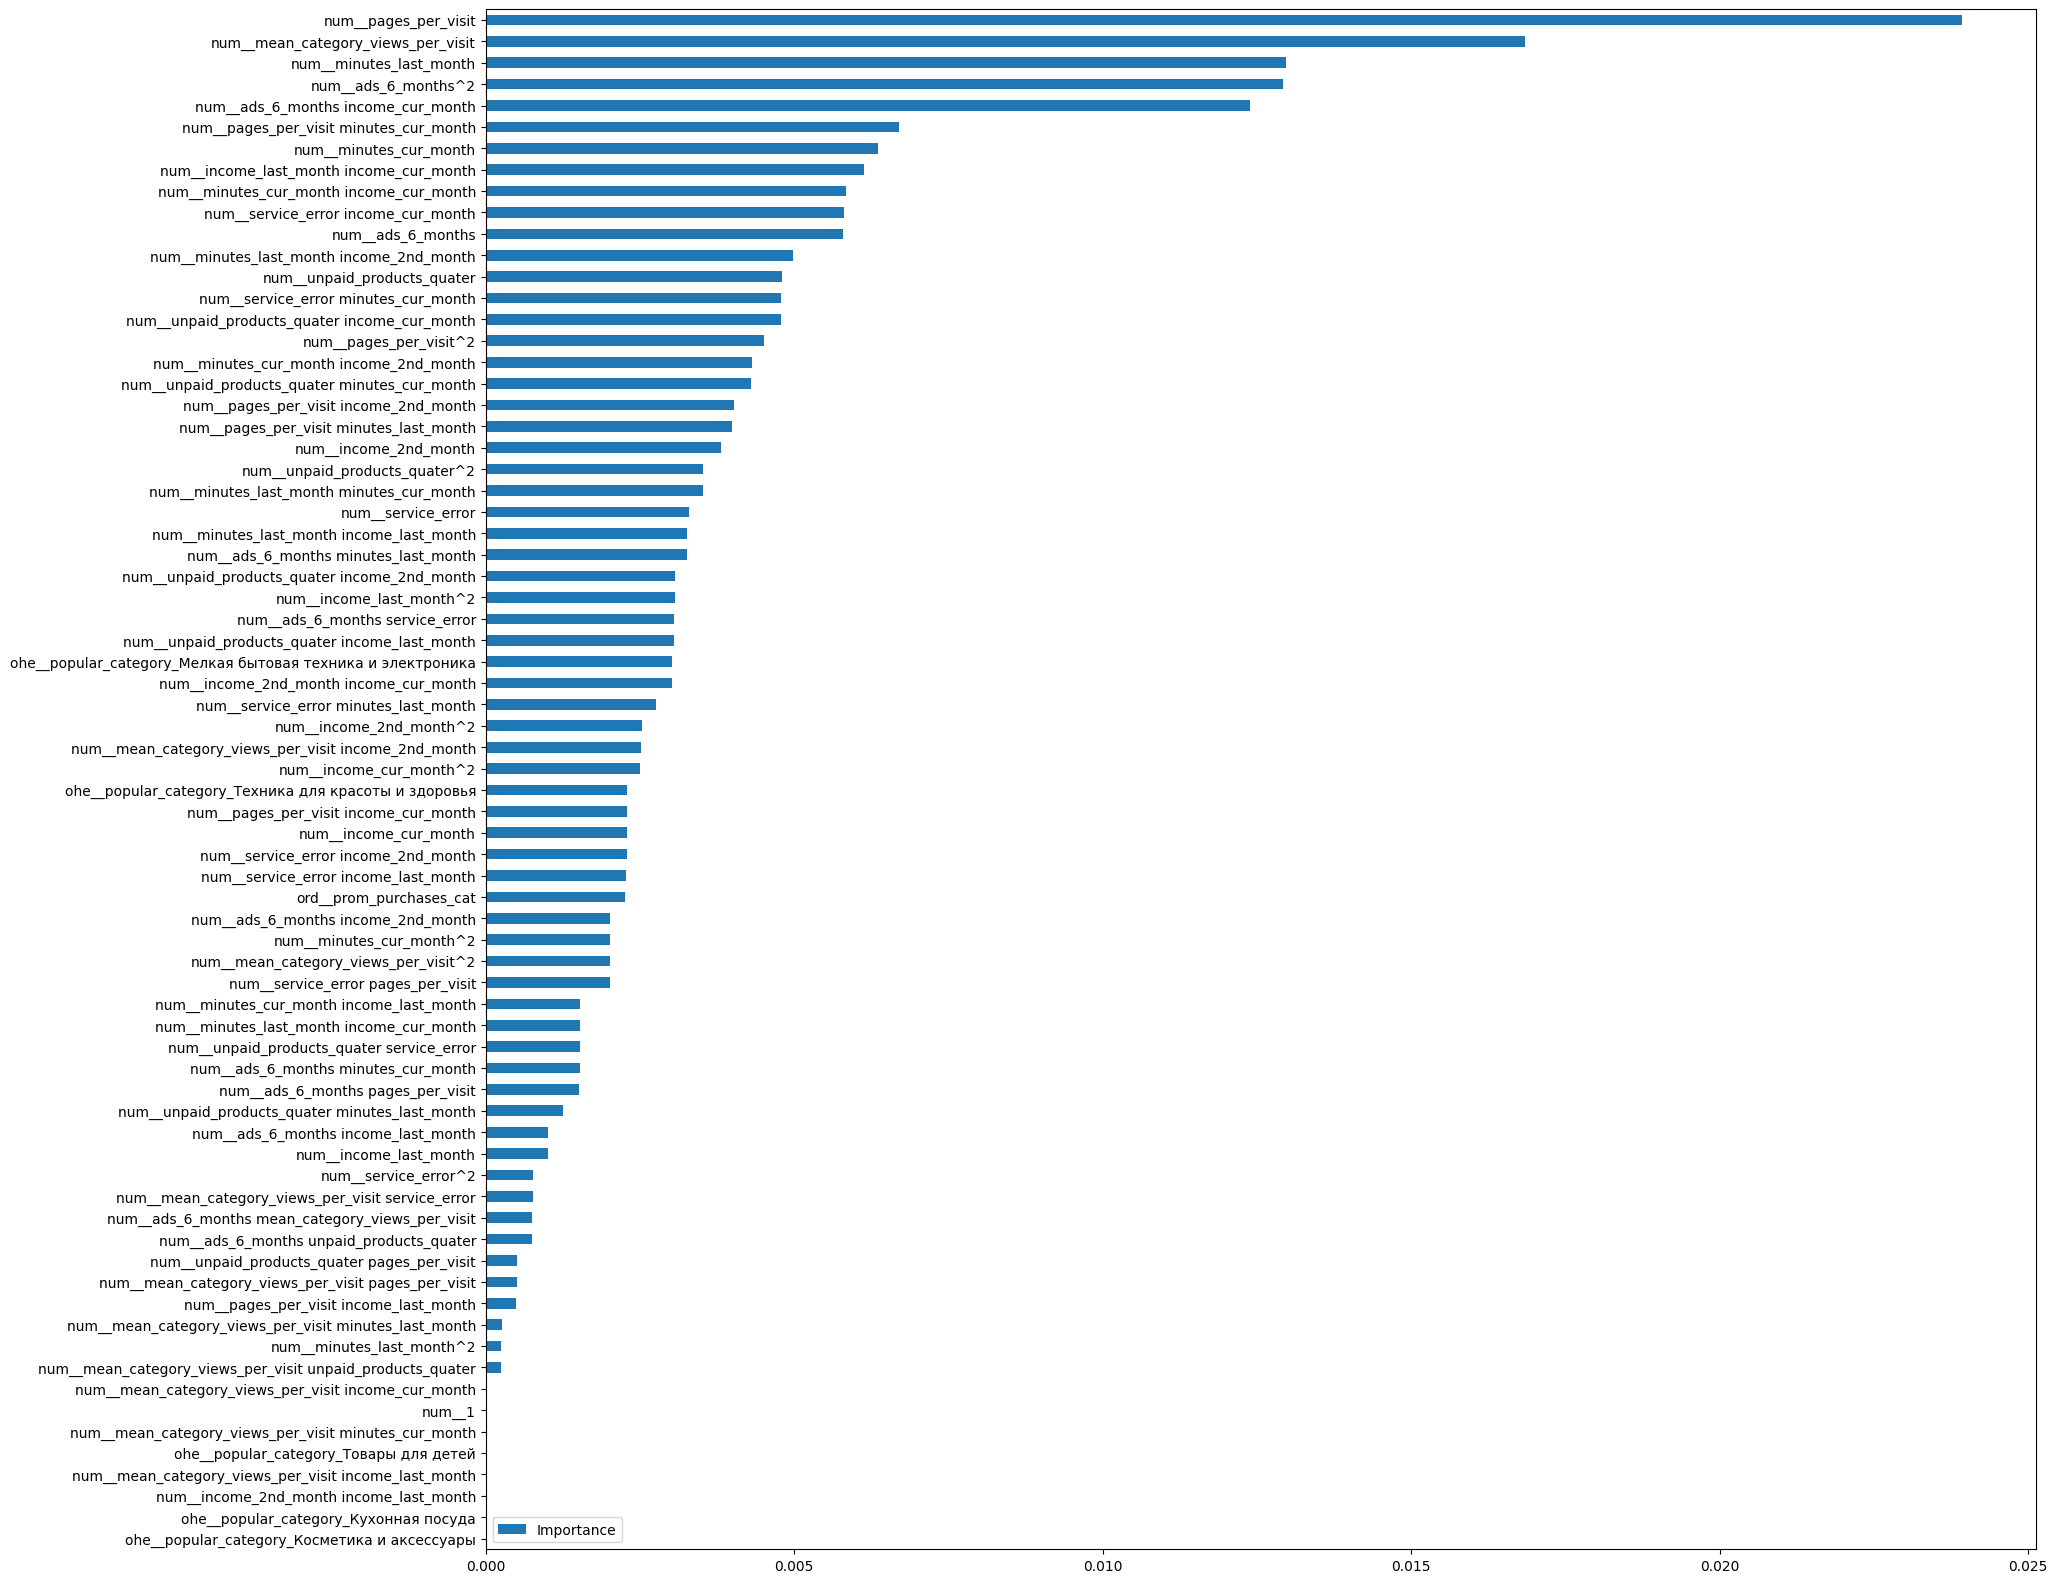

In [198]:
result = permutation_importance(clf, X_test_trans, y_test, scoring='f1')

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(result['importances_mean'])})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(20, 20), ylabel='', xlabel='')
plt.show()

Можно сказать, что:
- на активность пользователей значительно влияет время, проведенное на сайте
- на активность пользователей значительно влияет количество купленных товаров по акции
- на активность пользователей значительно влияет количество просмотренных страниц
- на активность пользователей влияет количество просмотренных категорий

Анализ с помощью метода SHAP

In [201]:
data = pd.DataFrame(X_test_trans, columns=feature_names)
background = shap.sample(data, 50, random_state=42)
explainer = shap.KernelExplainer(clf.predict_proba, background)
shap_values = explainer(X_test_trans)

  0%|          | 0/324 [00:00<?, ?it/s]

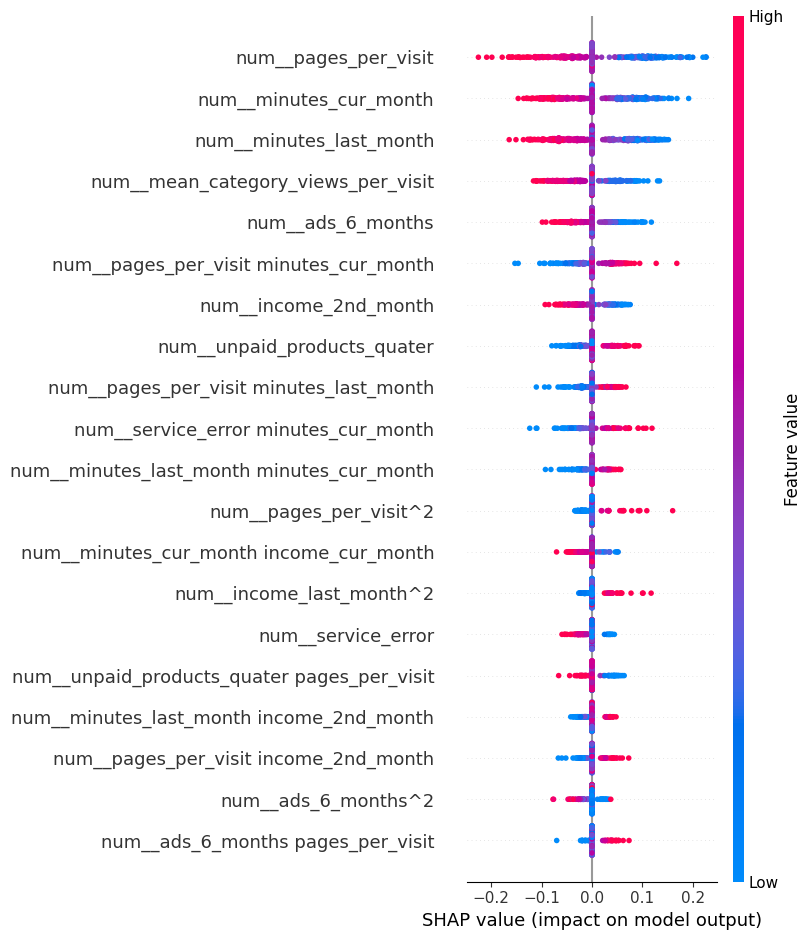

In [202]:
sv = shap_values.values[..., 1]
shap.summary_plot(sv, X_test_trans, feature_names=feature_names)

Сравнивая диаграмму beeswarm с графиком permutation importance, можно увидеть, что в общем признаки располагаются примерно в том же порядке за редкими исключениями

- признак минут предыдущий/текуший месяц, а также его квадрат положительно влияют на активность пользователей. Это означает, что время, проведенное на сайте, оказывает положительное влияние на активность пользователя
- признак страниц за визит положительно влияет на активность пользователей. Это означает, что пользователи, которые просматривают больше страниц, склонны остаться на сайте
- высокое количество неоплаченных товаров негативно сказывается на активности пользователя

Отбор признаков

Напишем функцию для вывода признаков с их влиянием:

In [206]:
result = permutation_importance(
    clf, X_test_trans, y_test,
    scoring='f1', n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
)
feat_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
imp_df = (pd.DataFrame({
    'feature': feat_names,
    'importance': np.abs(result.importances_mean),
    'std': result.importances_std
})
 .sort_values('importance', ascending=False)
 .reset_index(drop=True))
imp_df.head(15)

feature  importance       std
0                                num__pages_per_visit    0.034231  0.008729
1                             num__minutes_last_month    0.014218  0.012849
2                  num__mean_category_views_per_visit    0.011175  0.008296
3              num__pages_per_visit minutes_cur_month    0.008997  0.007209
4                                 num__ads_6_months^2    0.008487  0.005768
5             num__minutes_cur_month income_cur_month    0.006719  0.006342
6            num__minutes_last_month income_2nd_month    0.006141  0.004480
7                            num__income_last_month^2    0.005814  0.004350
8                                   num__ads_6_months    0.005544  0.009264
9                  num__ads_6_months income_cur_month    0.005200  0.003932
10                             num__minutes_cur_month    0.005166  0.004670
11  num__mean_category_views_per_visit income_2nd_...    0.004914  0.004213
12       num__unpaid_products_quater income_cur_month    0.004782  0.003015
13            num__income_last_month income_cur_month    0.004687  0.003589
14  num__mean_category_views_per_visit minutes_las...    0.004519  0.006266

In [207]:
y_pred_test = best_pipeline.predict(X_test)
score_test = f1_score(y_test, y_pred_test)
print(f'Test score: {score_test}')

Test score: 0.8584070796460177


<a class='anchor' id='eighth-bullet'></a>
## Сегментация пользователей

Рассмотрим, какие признаки влияют на прибыльность клиентов для компании. Для этого объединим датасеты и построим матрицу корреляции

In [210]:
data_pr = data_cor.merge(data_income, on='id')

In [211]:
print(data_cor.shape)
print(data_income.shape)
print(data_pr.shape)

(1296, 13)
(1300, 1)
(1296, 14)


In [212]:
data_pr.head()

customer_activity  ads_6_months   popular_category  \
id                                                          
215349         Снизилась           4.4   Товары для детей   
215350         Снизилась           4.9  Домашний текстиль   
215351         Снизилась           3.2   Товары для детей   
215352         Снизилась           5.1   Товары для детей   
215353         Снизилась           3.3  Домашний текстиль   

        mean_category_views_per_visit  unpaid_products_quater  service_error  \
id                                                                             
215349                              4                       4              2   
215350                              5                       2              1   
215351                              5                       0              6   
215352                              3                       2              3   
215353                              4                       1              1   

        pages_per_visit prom_purchases_cat  minutes_last_month  \
id                                                               
215349                5               >70%                  12   
215350                5               <70%                   8   
215351                4               >70%                  11   
215352                2               >70%                   8   
215353                4               <70%                  10   

        minutes_cur_month  income_last_month  income_2nd_month  \
id                                                               
215349                 10             5216.0            4472.0   
215350                 13             5457.5            4826.0   
215351                 13             6158.0            4793.0   
215352                 11             5807.5            4594.0   
215353                 10             4738.5            5124.0   

        income_cur_month  income  
id                                
215349            4971.6    4.16  
215350            5058.4    3.13  
215351            6610.4    4.87  
215352            5872.5    4.21  
215353            5388.5    3.95

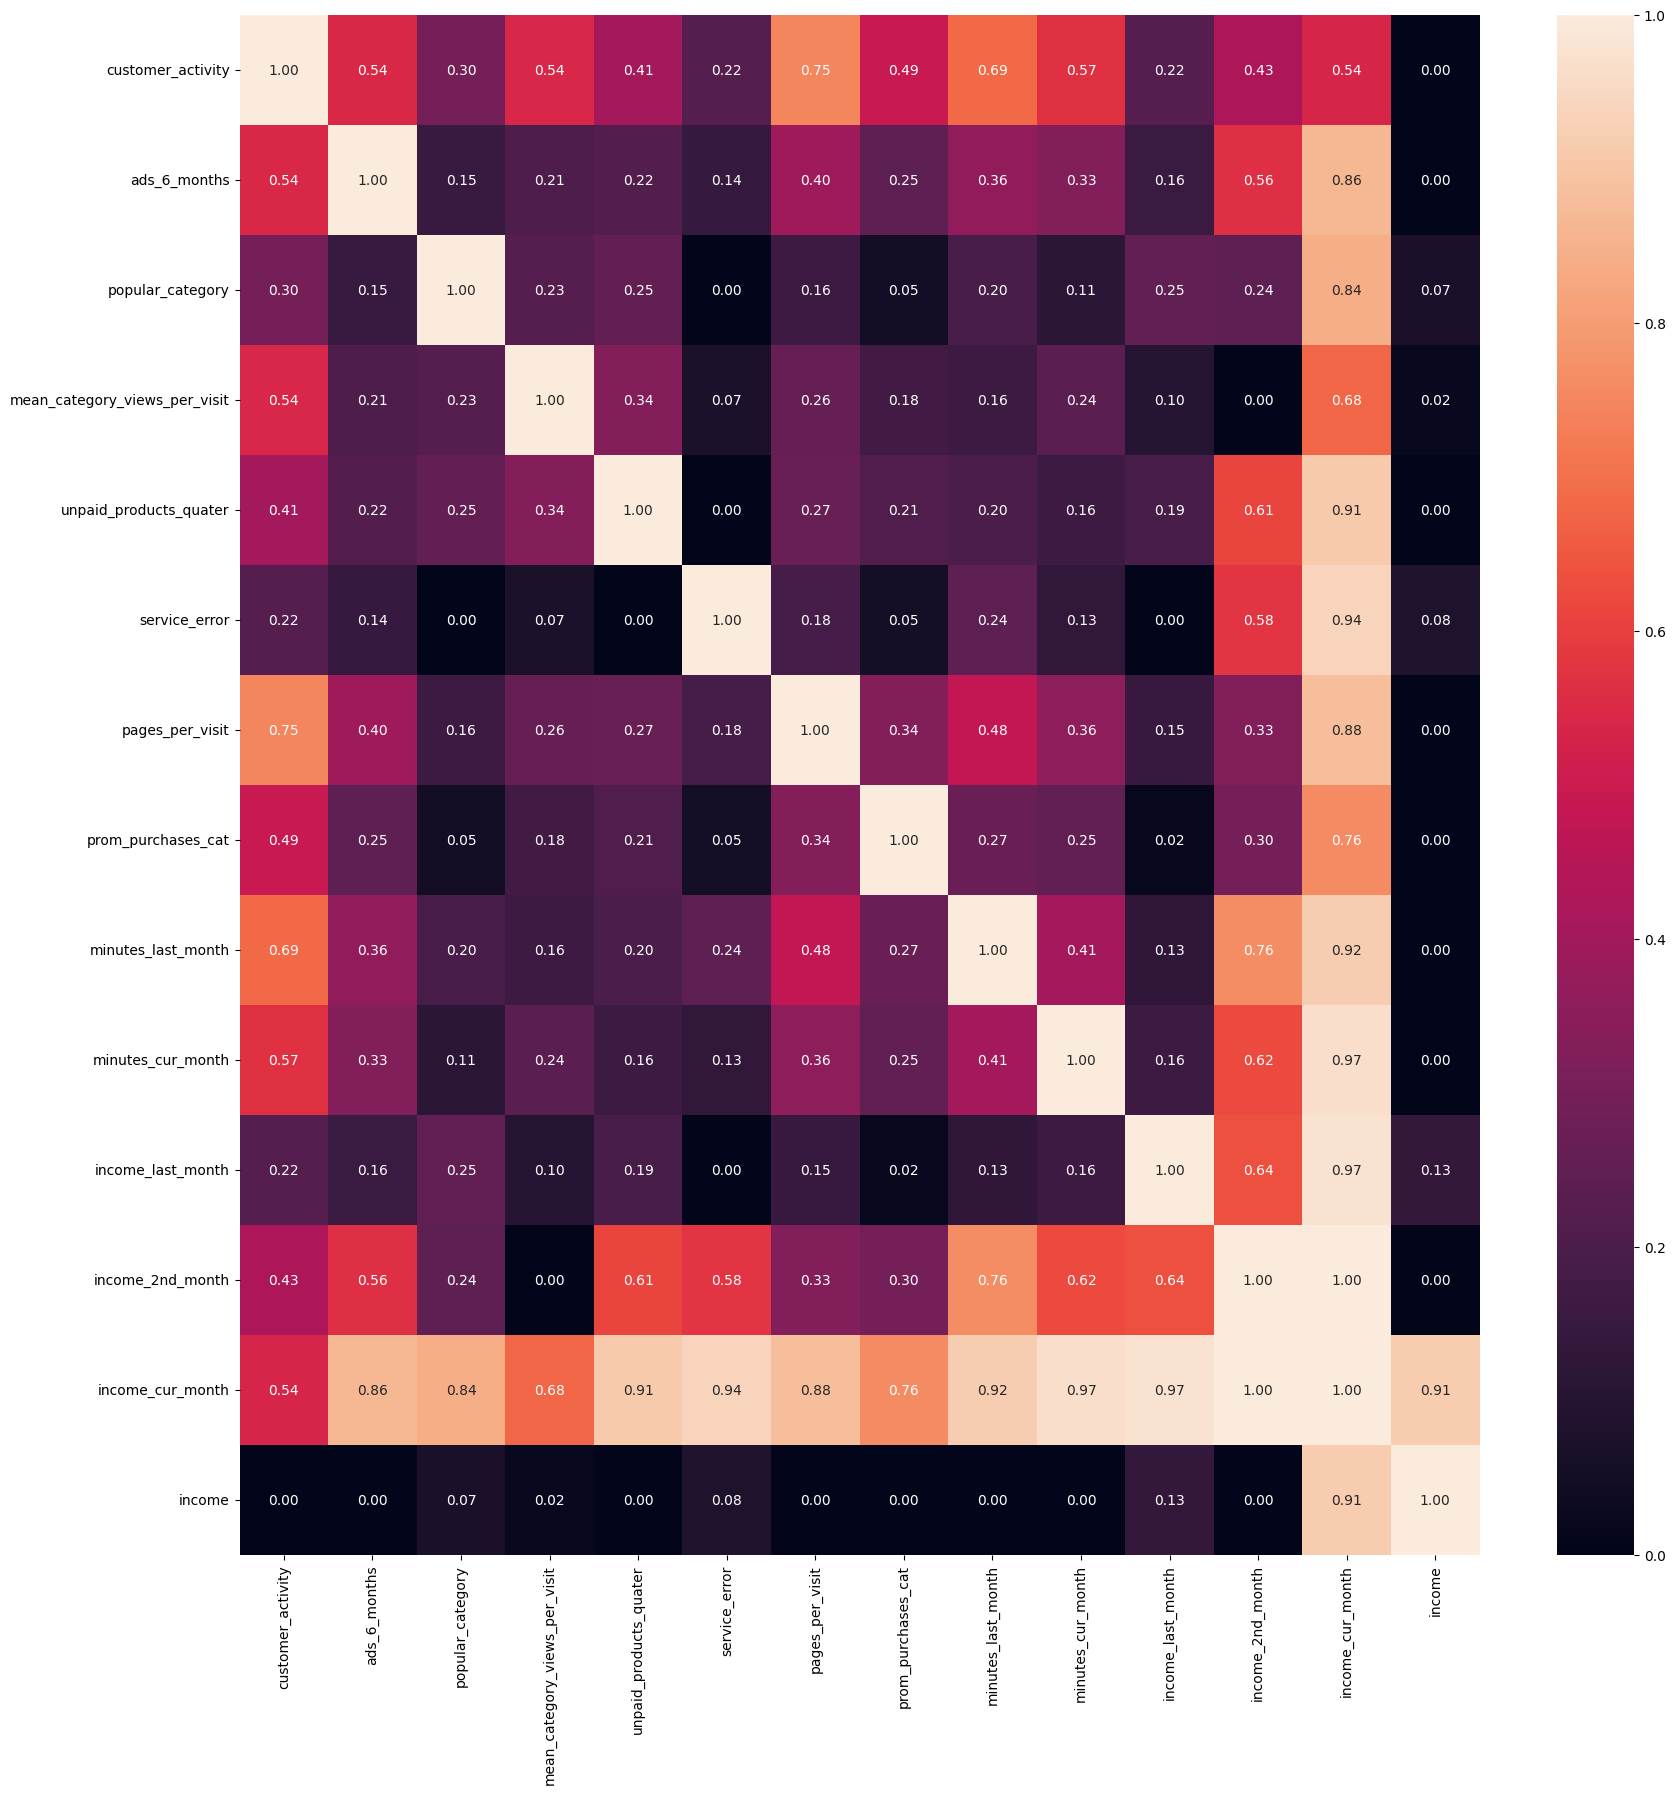

In [213]:
interval_cols = {
    'ads_6_months',
    'mean_category_views_per_visit',
    'pages_per_visit',
    'service_error',
    'minutes_last_month',
    'income_last_month',
    'income'
}

plt.figure(figsize=(20, 20))

sns.heatmap(
    data_pr.phik_matrix(
        interval_cols=interval_cols,
    ), annot=True, fmt='.2f'
)

plt.show()

Можно увидеть, что на прибыльность влияют признаки ошибка сервиса, средний просмотр категорий за визит и популярная категория

In [215]:
series = best_pipeline.predict_proba(
    data_pr.drop(
        ['income', 'customer_activity'], axis=1
    )
)[:,1]

data_pr['proba_reduce_activity'] = series

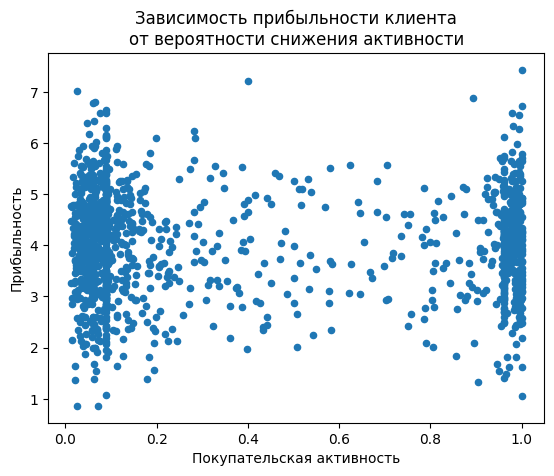

In [216]:
data_pr.plot.scatter(x='proba_reduce_activity',
                       y='income',
                       title='Зависимость прибыльности клиента\nот вероятности снижения активности',
                       xlabel='Покупательская активность',
                       ylabel='Прибыльность')
plt.show()

Имеет смысл проанализировать сегмент покупателей, активность которых, вероятно, снизится, и которые при этом принесли бы ощутимую прибыль. Проведем границу разделения вероятностей на отметке в 0.6, а границу для прибыли на отметке в 3

In [218]:
warning_data = data_pr[(data_pr['proba_reduce_activity'] >= 0.6) & (data_pr['income'] >= 3)]
safe_data = data_pr[~((data_pr['proba_reduce_activity'] >= 0.6) & (data_pr['income'] >= 3))]

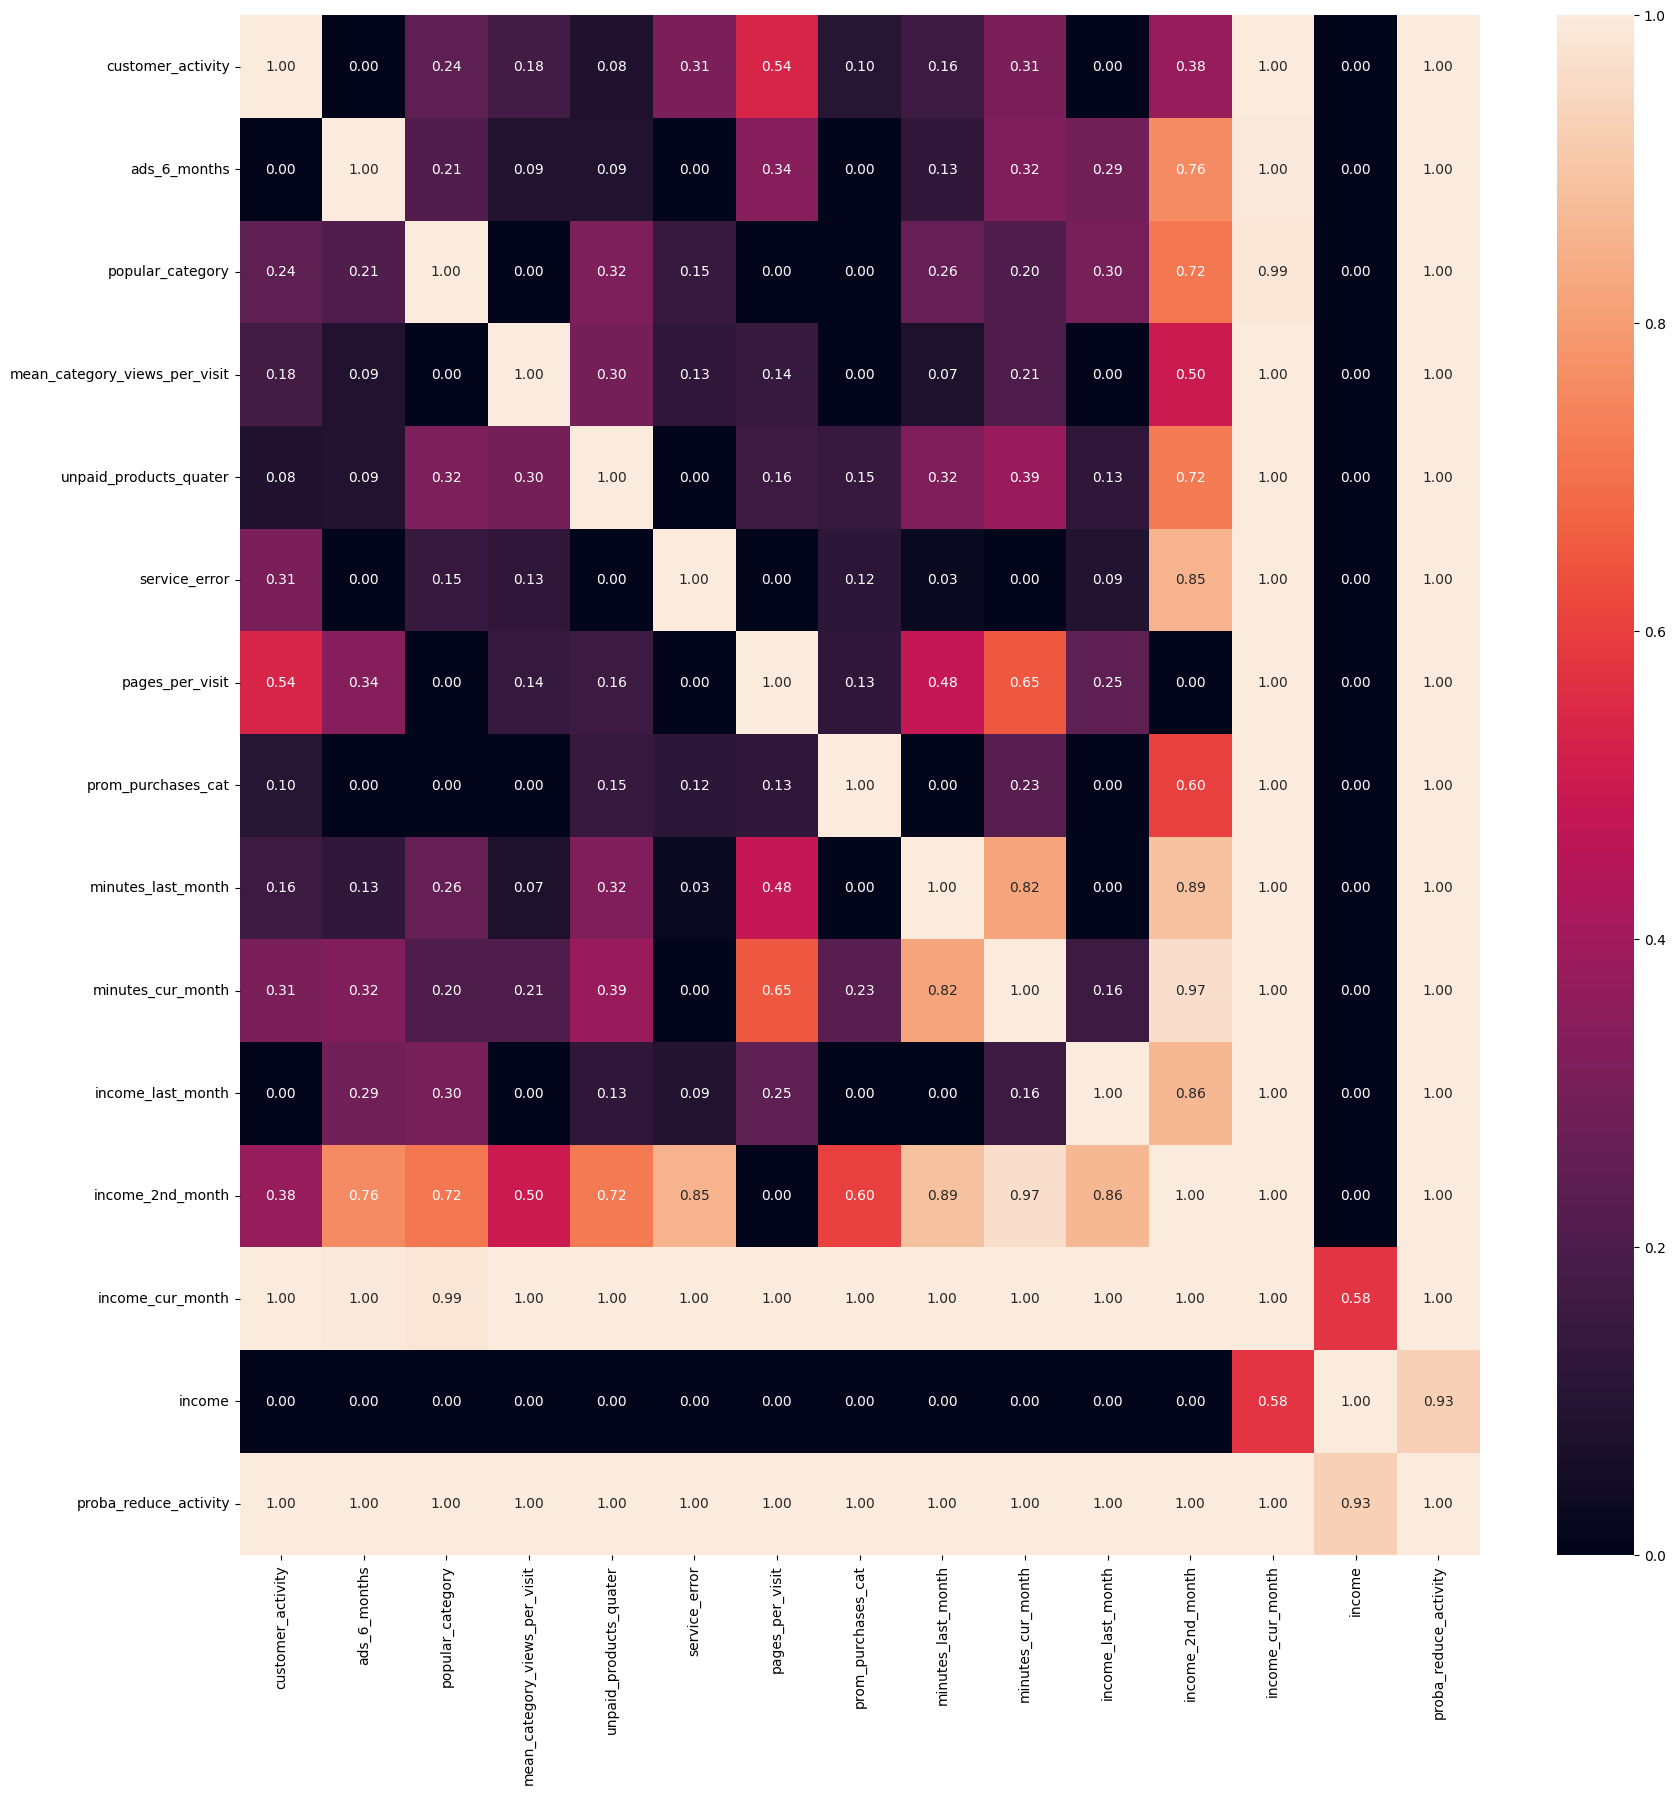

In [219]:
interval_cols = {
    'ads_6_months',
    'mean_category_views_per_visit',
    'pages_per_visit',
    'service_error',
    'minutes_last_month',
    'income_last_month',
    'income'
}

plt.figure(figsize=(20, 20))

sns.heatmap(
    warning_data.phik_matrix(
        interval_cols=interval_cols
    ), annot=True, fmt='.2f'
)

plt.show()

Можно заметить, что на покупательскую активность таких пользователей, сильнее влияет количество страниц, которое они просматривают, а также количество времени, проведенного на сайте. Построим графики для этих признаков и остальных

In [221]:
def show_scatter(data, ax, col_name, color):
    data.plot.scatter(ax=ax,
                       x=col_name,
                       y='proba_reduce_activity',
                       color=color,
                       title=f'Зависимость вероятности снижения активности\nцелевого пользователя от {col_name}',
                       xlabel=col_name,
                       ylabel='Покупательская активность')
def show_bar(data, ax, col_name, color):
    pivot = data.pivot_table(index=col_name, values='proba_reduce_activity', aggfunc='median')
    pivot.columns = ['median']
    pivot.sort_values(by='median', ascending=True, inplace=True)
    pivot.plot.barh(ax=ax,
                    color=color,
                    title=f'Зависимость вероятности снижения активности\nцелевого пользователя от {col_name}',
                    xlabel='',
                    ylabel='Покупательская активность')

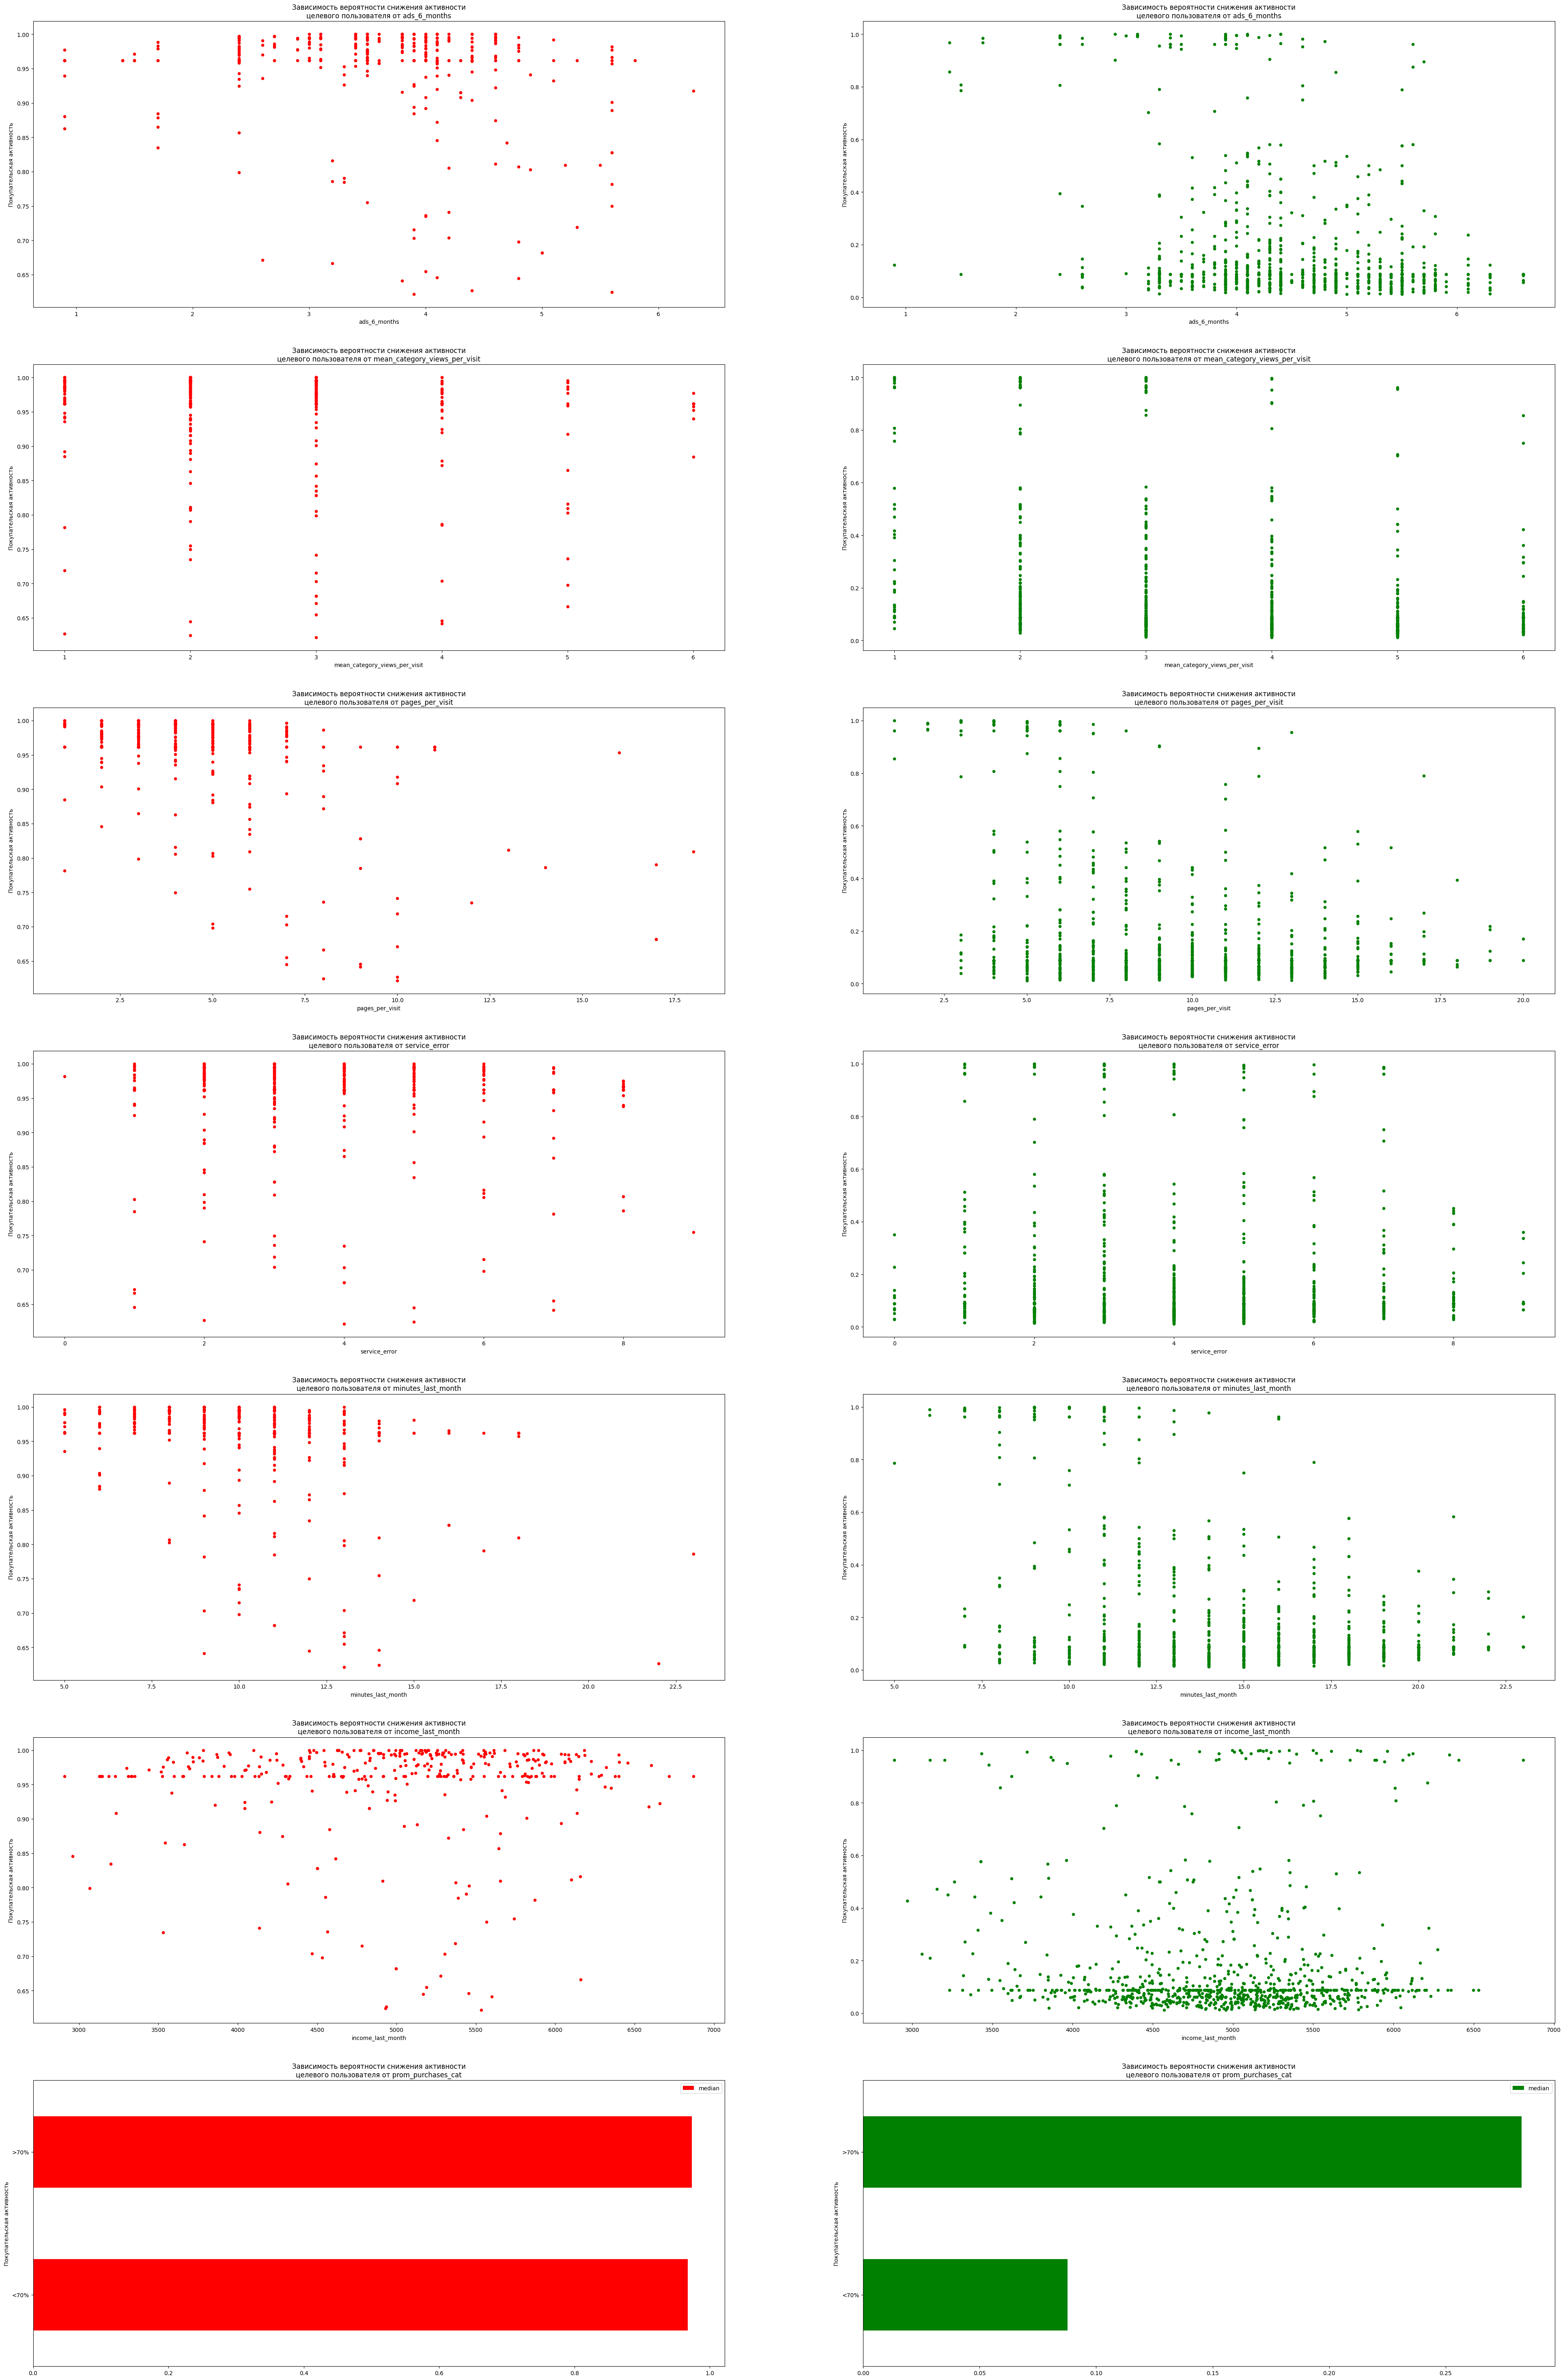

In [222]:
num_cols = [
    'ads_6_months',
    'mean_category_views_per_visit',
    'pages_per_visit',
    'service_error',
    'minutes_last_month',
    'income_last_month',
]

cat_cols = [
    'prom_purchases_cat',
]

fig, axes = plt.subplots(ncols=2, nrows=7, figsize=(20, 20))

for i in range(0, 6):
    show_scatter(warning_data, axes[i, 0], num_cols[i], 'red')
    show_scatter(safe_data, axes[i, 1], num_cols[i], 'green')

for i in range(6, 7):
    show_bar(warning_data, axes[i, 0], cat_cols[i - len(num_cols)], 'red')
    show_bar(safe_data, axes[i, 1], cat_cols[i - len(num_cols)], 'green')

plt.subplots_adjust(right=2, top=3)
plt.show()

Можно заметить, что в целевом сегменте в отличие от группы остальных пользователей:
- высока вероятность потери клиента при большом количестве маркетинговых взаимодействий (возможно, целевые пользователи не очень любят рекламу и звонки)
- высокое вероятность того, что большое количество акционных покупок служит маркером снижения активности в дальнейшем
- низкое количество категорий, просматриваемых за визит, увеличивает вероятность потери клиента
- низкое количество страниц, просмотренных за визит, ощутимо снижает вероятность удержать пользователя
- наличие ошибок сервиса отпугивает клиентов
- малое количество времени, проводимого на сайте, способствует потере клиента
- различаются лидирующие популярные категории. Среди целевых клиентов наиболее популярны товары для детей, домашний текстиль и кухонная посуда
- целевые клиенты не склонны заполнять корзину "на будущее". Многие из них не держат в корзине неоплаченных продуктов

<a class='anchor' id='ninth-bullet'></a>
## Общий вывод

При помощи анализа данных методом SHAP я рекомендую:

- вкладывать наибольшие ресурсы в развитие рекомендательной системы (чтобы пользователи, которые просто листают сайт, начали делать покупки);
- создать систему скидок и акций для постоянных пользователей. Это позволит удержать любителей скидок;

Для анализа был выбран сегмент, в котором пользователи имеют наибольшую вероятность снизить активность, и при этом имеют наибольшую потенциальную прибыль.

По результатам анализа по сегментам я рекомендую:

- стараться проводить маркетинговые взаимодействия ненавязчиво;
- не делать упор на акции. Можно сказать, что они расширяют охват, но портят качество аудитории;
- иногда провоцировать пользователя переходить в другие категории;
- вкладывать наибольшие ресурсы в развитие рекомендательной системы. Это поможет удержать пользователя на сайте и вдохновить его на дальнейшее пролистывание;
- необходимо стараться уменьшать количество ошибок на сайте;